# Hairpin 3 in 300 mM NaCl, nsALEX


## Purpose:

**burstH2MM** greatly streamlined the analysis of diffusion based confocal single molecule data with mpH<sup>2</sup>MM, by providing direct interface between [H2MM_C](https://h2mmpythonlib.readthedocs.io) and [FRETBursts](https://fretbursts.readthedocs.io/latest/).
It also calculates many derived parameters specific to single molecule-FRET and TCSPC measuremens, for which it was not appropriate to integrate their calculations directly into [H2MM_C](https://h2mmpythonlib.readthedocs.io).

> **Note**
>
> **burstH2MM** is a **wrapper** around [H2MM_C](https://h2mmpythonlib.readthedocs.io) and [FRETBursts](https://fretbursts.readthedocs.io/latest/).
> This means when you use **burstH2MM** you are using [H2MM_C](https://h2mmpythonlib.readthedocs.io) and [FRETBursts](https://fretbursts.readthedocs.io/latest/) under the hood.
> It is not a replacement, it is an interface and management system.

Therefore, in addition to the other documentation, it seemed appropriate to update teh code in [Harris et. al. Nature Communications, 2022, 12, 1000](https://doi.org/10.1038/s41467-022-28632-x) using **burstH2MM**. 

That is this notebook
This means that this notebooks is something of a hybrid between a demonstration, tutorial and analysis inteded for publication (i.e. a template for your own analysis).

The text and structure have been kept largely the same as the original, with changes reflecting the switch to using the **burstH2MM**.

There are rare updates when after more experience with H<sup>2</sup>MM it was found that an alternative means of calcualtion and/or analysis was more appropriate.
But for the most part **burstH2MM** merely simplifies the code.
One area where this notebook departs from the original is regarding characterizing uncertainties, as **burstH2MM** now implements more advanced analysis of uncertainty compared to the original notebook.

> **Note**
>
> This particualar notebook specifically recreates [H2MM-Multidimensional-Example-PIE_HP3_TE300_SPC630-AutoChoose-ICL-nanotime.ipynb](https://www.zenodo.org/record/5902313/files/H2MM-Multidimensional-Example-PIE_HP3_TE300_SPC630-AutoChoose-ICL-nanotime.ipynb?download=1)
>
> The data file used in this notebook can be downloaded here: [HP3_TE300_SPC630.hdf5](https://zenodo.org/record/5902313/files/HP3_TE300_SPC630.hdf5)

For a tutorial on [FRETBursts](https://fretbursts.readthedocs.io/latest/), the documentation includes a number of tutorial notebooks: [primary tutorial](https://nbviewer.jupyter.org/github/OpenSMFS/FRETBursts_notebooks/blob/master/notebooks/FRETBursts%20-%20us-ALEX%20smFRET%20burst%20analysis.ipynb), [github tutorial notebooks](https://github.com/OpenSMFS/FRETBursts_notebooks).


<a id='importmodules'></a>
## Environment setup

For those new to python, you import modules to access various functionalities.

It is generally best practice to import all modules that you will use at the beginning of your code.

But, strictly speaking, the can be imported right before the first time they are used.

So let's get our import out of the way

In [1]:
# Basic python modules to look at files and time the execution of code
import time
begin = time.perf_counter()
import os
from itertools import combinations
from itertools import chain
from math import comb

# standard scientific Python modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

# FRETBursts and H2MM moduels
import fretbursts as frb
from fretbursts.phtools.phrates import *
import burstH2MM as bhm
# NOTE: only used to create initial models, to mimic original strategy, normal analysis
# will not need this
import H2MM_C as hmm

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7.1).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


The `printtime` function is just useful for benchmarking- it finds the difference between two times given by `time.perf_counter` into a human readable hours-minutes-seconds format, the `preamble` kwarg lets us add message in front of the time output (so we can say if this is supposed to be the time for the whole notebook, an optimization etc).

In [2]:
def printtime(beg, fin , preamble=None):
    """
    Simple function to plot time between to clock variables
    Parameters
    ----------
    beg : float
        begining of duration, value returned by time.perfcounter()
    fin : float
        ending of duration, value returned by time.perfcounter()
    preamble : str, optional
        Any text to describe period beign specified. The default is None"""
    if preamble is None:
        preamble = ''
    print("%s %dh %dm %.4fs to run"%(preamble,(fin - beg)//3600,(fin - beg)//60,(fin - beg)%60))

In [3]:
sns = frb.init_notebook()

## [FRETBursts](https://fretbursts.readthedocs.io/latest/) analysis

### Loading files

Now we load the file, you should place the path to the file on your system in the string following filename on the first line

**Select .hdf5 format Data File**

In [4]:
filename = 'HP3_TE300_SPC630.hdf5'

**Name of the dataset, will be printed in plots later**

In [5]:
plot_title = '../mpH2MMrevision/HP3 300mM NaCl' # main caption to put in the plots to identify the substrate

This cell just checks to make sure you have a real file (so the notebook won't proceed if you made a ** gasp ** typo in your filename.

In [6]:
if os.path.isfile(filename):
    print('Perfect, I found the file!')
else:
    raise OSError('ERROR: file does not exist')

Perfect, I found the file!


**Load file into FRETBursts**

In [7]:
d = frb.loader.photon_hdf5(filename)
# sort out of order photons, there are very few of these, and result as crosstalk between channels
for i in range(len(d.ph_times_t)):
    indeces = d.ph_times_t[i].argsort()
    d.ph_times_t[i], d.det_t[i] = d.ph_times_t[i][indeces], d.det_t[i][indeces]

Now let's see some basic statistics on our data:
first, the length of the observation (in seconds):

In [8]:
d.time_max

5009.352951850001

Now lets see the alternation histogram- make sure the assignment of donor and acceptor regions are assigned correctly

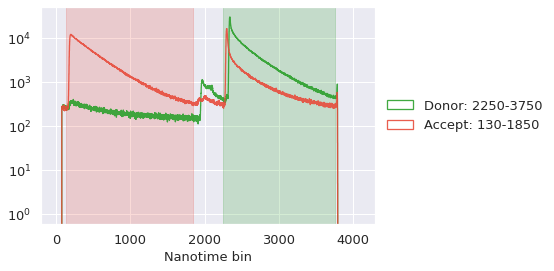

In [9]:
frb.bpl.plot_alternation_hist(d)

Since the alternation histogram looks good, analysis can proceed by applying the ALEX period

In [10]:
frb.loader.alex_apply_period(d)

# Total photons (after ALEX selection):    11,414,157
#  D  photons in D+A excitation periods:    5,208,392
#  A  photons in D+A excitation periods:    6,205,765
# D+A photons in  D  excitation period:     6,611,308
# D+A photons in  A  excitation period:     4,802,849



With photons sorted into their respective streams (D<sub>ex</sub>D<sub>em</sub>, D<sub>ex</sub>A<sub>em</sub>, A<sub>ex</sub>D<sub>em</sub>, A<sub>ex</sub>A<sub>em</sub>) it is good to check if the data is of sufficient quality, a short section timetrace of photon count rate is plotted. 
Bursts (which appear as spikes in the plot) should be well separated from each other to avoid ensemble averaging. 
If they are not, the concentration of labeled molecule(s) is too high, and thus should be decreased.

<AxesSubplot:title={'center':'HP3_TE300_SPC630'}, xlabel='Time (s)', ylabel='# ph'>

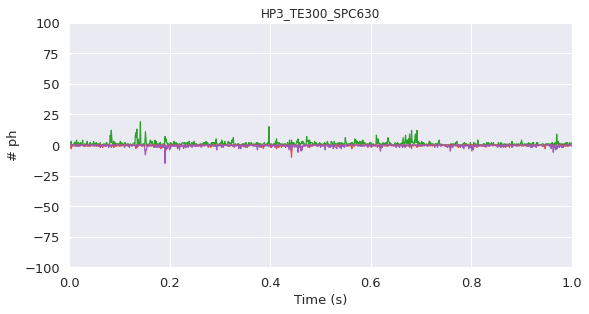

In [11]:
frb.dplot(d, frb.timetrace)

Since the time trace appears of sufficient quality, further calculations can proceed.

The background is calculated, and the histogram of interphoton times is plotted to show the overall photon background rates. The rates are calculated for time_s=30 second intervals

<a id='background'></a>
### Background calculation

> **Note**
>
> These are rarely changed

In [12]:
d.calc_bg(fun=frb.bg.exp_fit,time_s=30, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... Channel 0
[DONE]


Now various plots are presented to make sure there are no problems with the data.

The first is the histogram of the inter-photon delays, which are used to calculated the background.

<AxesSubplot:title={'center':'HP3_TE300_SPC630'}, xlabel='Inter-photon delays (ms)', ylabel='# Delays'>

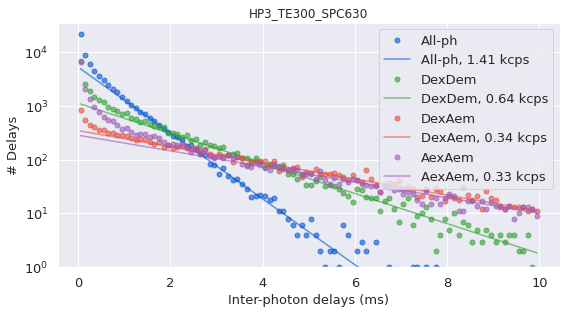

In [13]:
frb.dplot(d, frb.hist_bg)

It is also helpful to see how the background change with time. So the plot of the background rates for all time_s=30 second intervals of the 

<AxesSubplot:title={'center':'HP3_TE300_SPC630'}, xlabel='Time (s)', ylabel='BG rate (kcps)'>

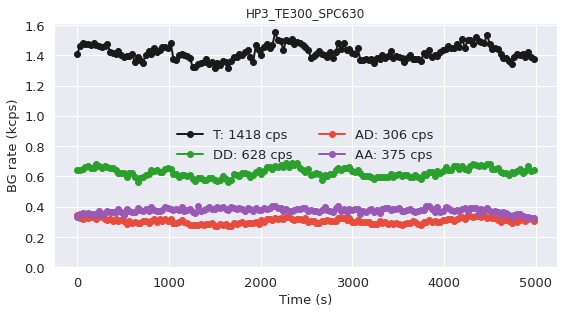

In [14]:
frb.dplot(d, frb.timetrace_bg)

<AxesSubplot:title={'center':'HP3_TE300_SPC630'}, xlabel='Time (s)', ylabel='# ph'>

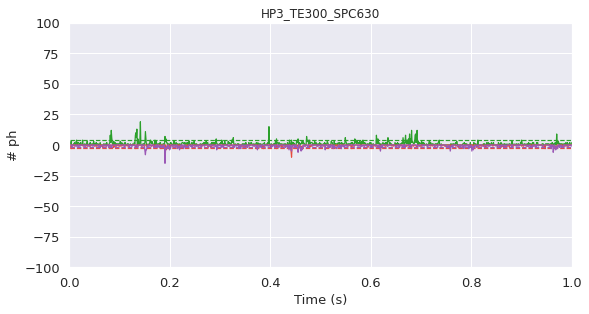

In [15]:
frb.dplot(d, frb.timetrace)

The burst search is performed, using the thresholds of m=10 consecutive photons, whose overall count rate is F=6 times higher than the background.

<a id='acbs'></a>
### All-Channel Burst Search (ACBS)

> **Note**
>
> The size of the sliding window is set with the `m` parameter.
> The photon rate threshold above the background to select a burst is set with the `F` parameter.

In [16]:
d.burst_search(m=10, F=6)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


In [17]:
d = d.fuse_bursts(ms=0)

 - - - - - CHANNEL  1 - - - - 
 --> END Fused 35558 bursts (20.0%, 9 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A and FRET]


<a id='burstselect'></a>
### Donor Active burst selection with All-Channel Burst Search (ACBS)
#### Donor Active burst selection
Next, bursts are filtered/selected to have a sum of $\geq$ 30 photons in all channels. This d_all includes all bursts, including the Donor Only (DO) and Acceptor Only (AO) bursts, which can be used to calculate the leakage and direct excitation factors respectively.

The uncorrected E-S histogram is then plotted.

$E_{raw} = \frac{n^A_D}{n^A_D + n^D_D}$

$S_{raw} = \frac{n^A_D + n^D_D}{n^A_D + n^D_D + n^A_A}$

[Lee, N. K.; Kapanidis, A. N.; Wang, Y.; Michalet X.; Mukhopadhyay, J.; Ebright R. H.; Weiss, S. 2005. Accurate FRET Measurements within Single Diffusing Biomolecules Using Alternating-Laser Excitation. <i>Biophys J.</i> 88:2939-2953](https://doi.org/10.1529/biophysj.104.054114)

<a id='daburstselect'></a>
**Theshold of bursts for all photons**

<class 'matplotlib.figure.Figure'>


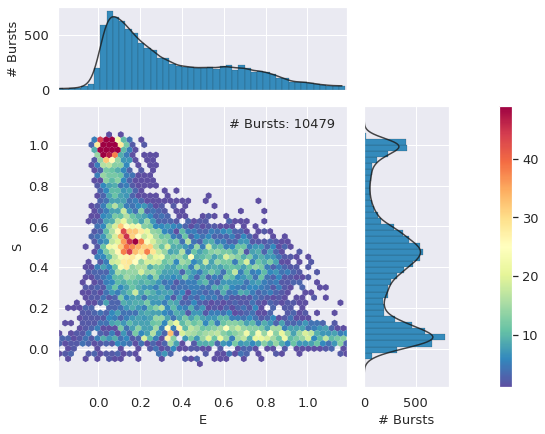

In [18]:
d_all = d.select_bursts(frb.select_bursts.size, add_naa=True, th1=50)

frb.alex_jointplot(d_all);

Now, bursts are selected for the same criterion, but excluding the A<sub>ex</sub>A<sub>em</sub> stream, thus selecting the bursts with an active donor, and are stored in `d_da` (DA for Donor Active)

**Threshold for bursts in D**<sub>ex</sub> **channels**

<class 'matplotlib.figure.Figure'>


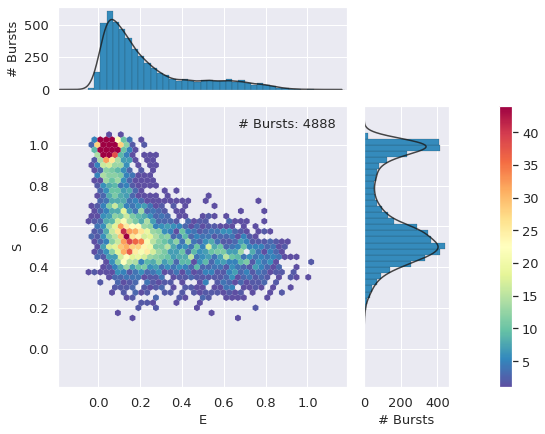

In [19]:
d_da = d_all.select_bursts(frb.select_bursts.size, th1=30)

frb.alex_jointplot(d_da);

<a id='fretburst_select'></a>
### FRET selection with Dual Channel Burst Search

There previous burst selection contains a large number of Acceptor inactive bursts.
One method for removing these is to set a minimum threshold of A<sub>ex</sub>A<sub>em</sub> photons, or to select bursts only within a certian range of $S_{raw}$.

A third method also exists, which is less arbitrary: the Dual Channel Bursts Search (DCBS), which treats the photon rates in the Donor and Acceptor channels separately, and bursts are only considered when both channels are above the threshold.

We will use the DCBS to isolate the FRET population:

#### DCBS burst search

> **Note**
>
> The `m` and `F` parameters have the same basic meaning as in the [ACBS](#acbs) selection

In [20]:
d_dcbs = frb.bext.burst_search_and_gate(d, m=10,F=6)

Deep copy executed.
Deep copy executed.
Deep copy executed.
 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Performing burst search (verbose=False) ... - Recomputing background limits for AexAem ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


#### DCBS burst search

<class 'matplotlib.figure.Figure'>


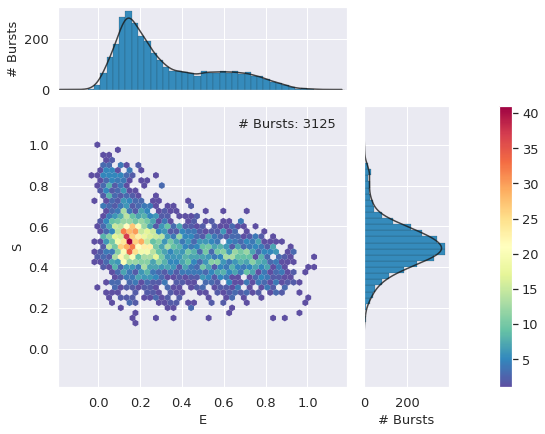

In [21]:
d_dcbs = d_dcbs.select_bursts(frb.select_bursts.size, add_naa=True, th1=60)

frb.alex_jointplot(d_dcbs);

#### DCBS burst selection

**Set minimum number of D**<sub>ex</sub>  **photons**

In [22]:
d_fret = d_dcbs.select_bursts(frb.select_bursts.size, add_naa=False, th1=30)

**Set minimum number of A**<sub>ex</sub>  **photons**

In [23]:
d_fret = d_fret.select_bursts(frb.select_bursts.naa, th1=30)

Now plot the results:

<class 'matplotlib.figure.Figure'>


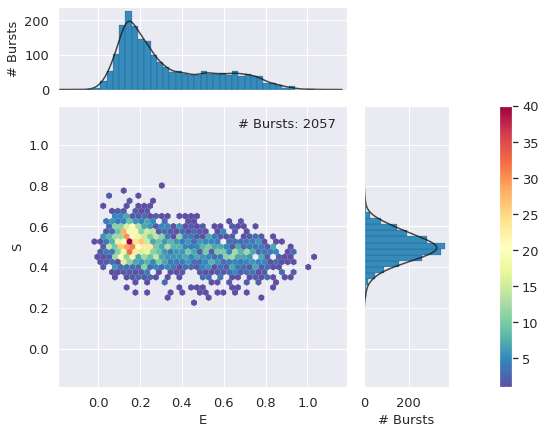

In [24]:
frb.alex_jointplot(d_fret);

<AxesSubplot:title={'center':'HP3_TE300_SPC630, #bu=2057'}, xlabel='E', ylabel='# Bursts'>

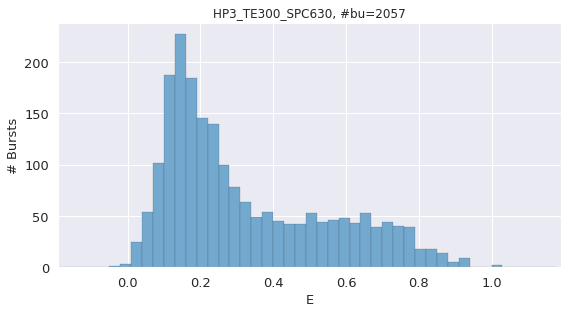

In [25]:
frb.dplot(d_fret, frb.hist_fret, pdf=False)

The above E histogram is indicative of a system undergoing intermediate to fast dynamics, as 2 gaussians are seen in the E plot, but a significant number of bursts have an intermediate FRET between the two states. 
These bursts can be suspected of undergoing dynamics within the burst. 
It can therefore be expected that the DNA hairpin is undergoing some form of interconversion at a time scale comparable to that of the burst duration.

Now let's see how long it took to do the FRETBursts analysis:

In [26]:
fb_time = time.perf_counter()
printtime(begin,fb_time,'FRETBurst analysis took: ')

FRETBurst analysis took:  0h 0m 17.1614s to run


As a preliminary test, Burst Variance Analysis is performed as a more rigorous test of fast dynamics.

<a id='BVA'></a>
## Burst Variance Analysis (BVA)
This is a computationally inexpensive test for fast dynamics, if BVA shows evidence of fast dynamics, H<sup>2</sup>MM is a promising method to extract both E<sub>raw</sub> and rates of interconversion. On the other hand, if BVA shows no evidence of fast dynamics, H<sup>2</sup>MM is likely to be fruitless.

BVA assesses how much the $PR$ varies within the burst. Each burst is divided into "sub-bursts" of $N$ donor excited photons (D<sub>ex</sub>). For a given sub-burst $i$ the $E^{*}_{i}$ is defined as:

$E^{*}_{i} = \frac{n^{DA}_{i}}{n^{DA}_{i}+n^{DA}_{i}} = \frac{n^{DA}_{i}}{N}$ as $N = n^{DD}_{i} + n^{DA}_{i}$

The standard deviation of $E^{*}$ for sub-bursts within a single burst is given as $\sigma_{E_{raw}}$:

$\sigma_{E}^{*} = \sqrt{\frac{\sum^{M}_{i}{(E^{*}_{i}}-\bar{E_{raw}})^{2}}{M}}$ 

where $\bar{E_{raw}} = \frac{\sum^{M}_{i}{E^{*}_{i}}}{M}$, which is the mean $E_{raw}$ of all sub-bursts, and the $E_{raw}$ of the burst itself.

For a molecule not undergoing dynamcis, the stochastic nature of FRET means that:

$\sigma_{E_{raw}} = \sqrt{\frac{\bar{E_{raw}}(1-\bar{E_{raw}})}{N}}$

This creates a semicircle in the plot of $\sigma_{E_{raw}}$ against $E_{raw}$, and thus if a population of bursts exists along this semicircle, it can be assumed no FRET dynamics are taking place at the time scale of $N$ inter-photon times, while populations which lie above this semicircle can be expected to have FRET dynamics.

Bursts below the semicircle indicate a problem in data processing. The most likely problem is too few sub-bursts in each burst for adequate assesment, in which case the burst selection and/or $N$ needs to be modified, or, worse, the data itself is somehow faulty.

[Torella, J. P.; Holden, S. J.; Santoso, Y.; Hohlbein, J.; Kapandidis, A. N.; 2011. Identifying Molecular Dynamics in Single-Molecule FRET Experiments with Burst Variance Analysis. <i>Biophys.J.</i>, 100: 1568-1577](https://doi.org/10.1016/j.bpj.2011.01.066)

**Define BVA function**

In [27]:
def bin_bva(E, std, R, B_thr):
    E, std = np.concatenate(E), np.concatenate(std)
    bn = np.linspace(0,1, R+1)
    std_avg, E_avg = np.empty(R), np.empty(R)
    for i, (bb, be) in enumerate(zip(bn[:-1], bn[1:])):
        mask = (bb <= E) * (E < be)
        if mask.sum() > B_thr:
            std_avg[i], E_avg[i] = np.mean(std[mask]), np.mean(E[mask])
        else:
            std_avg[i], E_avg[i] = -1, -1
    return E_avg, std_avg

def BVA(data, chunck_size):
    """
    Perform BVA analysis on a given data set.
    Calculates the std dev E in each burst.
    ----------
    d: FRETBursts data object
        A FRETBursts data object, must have burst selection already performed.
    chunk_size: int
        Size of the sub-bursts to assess E
    Returns
    -------
    E_eff: list[np.ndarray[float]]
        Raw FRET efficiency of each burst
    std_E: list[np.ndarray[float]]
        Standard deviation of FRET values of each burst
        
    """
    E_eff, std_E = list(), list()
    for ich, mburst in enumerate(data.mburst): # iterate over channels
        # create lists to store values for burst in channel
        stdE, E = list(), list()
        # get masking arrays before iterating over bursts
        Aem = data.get_ph_mask(ich=ich, ph_sel=frb.Ph_sel(Dex='Aem')) # get acceptor instances to calculate E
        Dex = data.get_ph_mask(ich=ich, ph_sel=frb.Ph_sel(Dex='DAem')) # get Dex mask to remove Aex photons
        for istart, istop in zip(mburst.istart, mburst.istop): # iterate over each burst
            phots = Aem[istart:istop+1][Dex[istart:istop+1]] # Dex photons in burst True if Aem and False if Dem
            # list of number of Aem in each chunch, easier as list comprehansion
            Esub = [phots[nb:ne].sum() for nb, ne in zip(range(0,phots.size, chunck_size), 
                                                         range(chunck_size,phots.size+1, chunck_size))]
            # Cacluate burst-wise value and append to list of bursts in channel
            stdE.append(np.std(Esub)/chunck_size) # calculate and append standard deviation
            E.append(sum(Esub)/(len(Esub)*chunck_size)) # calculate E
        
        # convert single-channel list to array and add to channel list
        E_eff.append(np.array(E)) 
        std_E.append(np.array(stdE))
    return E_eff, std_E     



**Define some constants for use in BVA analysis, and plotting of colors**

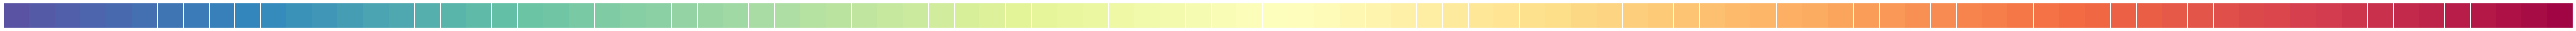

In [28]:
R = 20
n = 5
B_Thr = 40

plot_levels = 100
sns.palplot(sns.color_palette('Spectral_r', plot_levels))
BLUE = sns.color_palette('Spectral_r', plot_levels)[0]

<a id='bvada'></a>
**Plot the BVA of the Donor Active selection (**`d_da`**)**

Text(0.5, 1.0, 'Donor Active population')

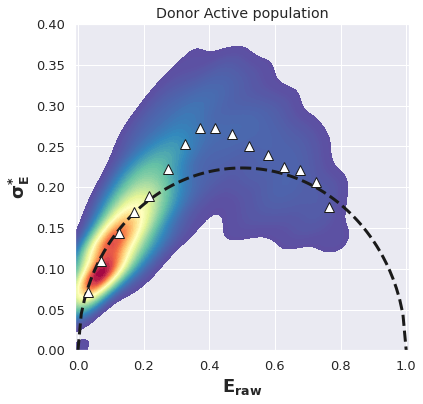

In [29]:
E_da, std_da = BVA(d_da, n)
E_da_bin, std_da_bin = bin_bva(E_da, std_da, R, B_Thr)
E_da, std_da = np.concatenate(E_da), np.concatenate(std_da)
# sns.set_style(style='darkgrid')
plt.figure(figsize=(6,6))
x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
plt.plot(x_T,y_T, lw=3, color='k', ls='--')
plt.plot (E_da_bin , std_da_bin, marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)
im = sns.kdeplot(x=E_da, y=std_da, shade=True, cmap='Spectral_r', n_levels=plot_levels, 
                 thresh=0.05, gridsize=100)
#plt.scatter(avg_da,std_da,alpha=0.1)
plt.xlim(-0.01,1.01)
plt.ylim(0,0.4)
plt.xlabel(r'$\mathbf{E_{raw}}$', fontsize=18)
plt.ylabel('$\mathbf{\sigma_{E}^{*}}$', fontsize=18)
plt.title('Donor Active population')
# plt.savefig(full_fname , dpi=200, bbox_inches='tight')

Text(0.5, 1.0, 'Donor Active population')

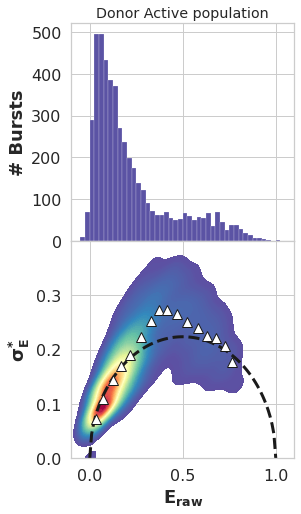

In [30]:
hist_bar_style={'facecolor': BLUE, 'alpha': 1, 'edgecolor': 'white', 'linewidth':0.2}

pnlsRows = 2
pnlsCols = 1
sns.set_style(style='whitegrid')
fig, ax = plt.subplots(pnlsRows, pnlsCols, sharex=True, figsize=(4*pnlsCols, 4*pnlsRows))
plt.subplots_adjust(hspace=0, wspace=0.2)

frb.dplot(d_da, frb.hist_fret, pdf=False, weights = None, 
          ax=ax[0], binwidth=0.025, hist_bar_style=hist_bar_style)

x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
ax[1].plot(x_T,y_T, lw=3, color='k', ls='--')


#ax[1].scatter(avg_da,std_da,alpha=0.1)
im = sns.kdeplot(x=E_da, y=std_da, shade=True, cmap='Spectral_r', 
                 n_levels=plot_levels, thresh=0.05, gridsize=100, ax=ax[1])

ax[1].plot (E_da_bin , std_da_bin, marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)
ax[1].set_ylim(0,0.4)
ax[1].set_yticks(np.arange(0, 0.4, 0.1))
for a in ax.ravel():
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_title('')
    a.set_xlim(-0.1,1.1)
    a.tick_params(axis='both', which='major', labelsize=16)
    a.tick_params(axis='both', which='minor', labelsize=14)

ax[0].set_ylabel('# Bursts', fontsize=18, fontweight='bold')
ax[1].set_ylabel('$\mathbf{\sigma_{E}^{*}}$', fontsize=18)
ax[1].set_xlabel('$\mathbf{E_{raw}}$', fontsize=18)
ax[0].set_title('Donor Active population')
# plt.savefig('HP3-300BVA.png', bbox_inches='tight')

Plot BVA of FRET burst selection. (`d_fret`)

<a id='bvafret'></a>
**Plot the BVA of the FRET burst selection (**`d_fret`**)**

Text(0.5, 1.0, 'FRET population')

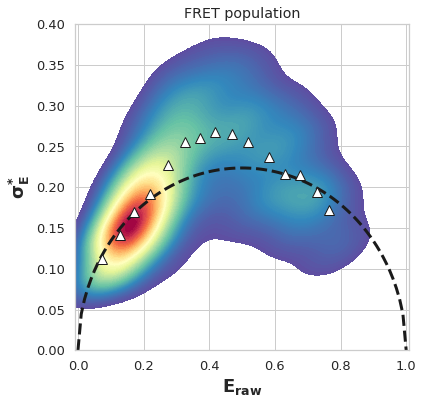

In [31]:
E_fret, std_fret = BVA(d_fret, n)
E_fret_bin, std_fret_bin = bin_bva(E_fret, std_fret, R, B_Thr)
E_fret, std_fret = np.concatenate(E_fret), np.concatenate(std_fret)

# sns.set_style(style='darkgrid')
plt.figure(figsize=(6,6))
x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
plt.plot(x_T,y_T, lw=3, color='k', ls='--')
plt.plot (E_fret_bin , std_fret_bin, marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)
im = sns.kdeplot(x=E_fret, y=std_fret, shade=True, cmap='Spectral_r', n_levels=plot_levels, 
                 thresh=0.05, gridsize=100)
#plt.scatter(avg_da,std_da,alpha=0.1)
plt.xlim(-0.01,1.01)
plt.ylim(0,0.4)
plt.xlabel('$\mathbf{E_{raw}}$', fontsize=18)
plt.ylabel('$\mathbf{\sigma_{E}^{*}}$', fontsize=18)
plt.title('FRET population')
# plt.savefig(full_fname , dpi=200, bbox_inches='tight')

Text(0.5, 1.0, 'FRET population')

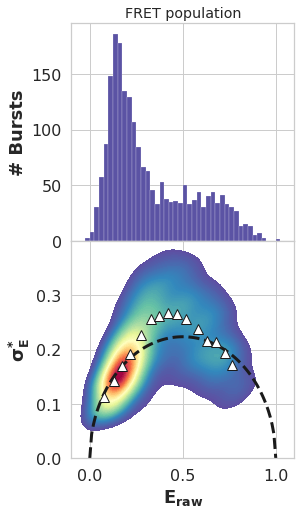

In [32]:
hist_bar_style={'facecolor': BLUE, 'alpha': 1, 'edgecolor': 'white', 'linewidth':0.2}

pnlsRows = 2
pnlsCols = 1
sns.set_style(style='whitegrid')
fig, ax = plt.subplots(pnlsRows, pnlsCols, sharex=True, figsize=(4*pnlsCols, 4*pnlsRows))
plt.subplots_adjust(hspace=0, wspace=0.2)

frb.dplot(d_fret, frb.hist_fret, pdf=False, weights = None, ax=ax[0], binwidth=0.025, 
          hist_bar_style=hist_bar_style)

x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
ax[1].plot(x_T,y_T, lw=3, color='k', ls='--')


#ax[1].scatter(avg_da,std_da,alpha=0.1)
im = sns.kdeplot(x=E_fret, y=std_fret, shade=True, cmap='Spectral_r', n_levels=plot_levels, 
                 thresh=0.05, gridsize=100, ax=ax[1])
ax[1].plot (E_fret_bin , std_fret_bin, marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)
ax[1].set_ylim(0,0.4)
ax[1].set_yticks(np.arange(0, 0.4, 0.1))
for a in ax.ravel():
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_title('')
    a.set_xlim(-0.1,1.1)
    a.tick_params(axis='both', which='major', labelsize=16)
    a.tick_params(axis='both', which='minor', labelsize=14)

ax[0].set_ylabel('# Bursts', fontsize=18, fontweight='bold')
ax[1].set_ylabel('$\mathbf{\sigma_{E}^{*}}$', fontsize=18)
ax[1].set_xlabel('$\mathbf{E_{raw}}$', fontsize=18)
ax[0].set_title('FRET population')
# plt.savefig('HP3-300BVA.png', bbox_inches='tight')

The above BVA plot is indicative of fast dynamcis, due to the significant portion of the plot existing above the $\sigma_E^*$ expected for FRET resulting from a single state binomial process. It is therefore valid to use H<sup>2</sup>MM to extract E and interconversion rates

In [33]:
bva_time = time.perf_counter()
printtime(fb_time,bva_time,'BVA took: ')

BVA took:  0h 0m 4.4891s to run


<a id='h2mm'></a>
## H<sup>2</sup>MM Analysis

We are now ready to begin H<sup>2</sup>MM analysis.


### Model Choice, Error and Viterbi Analysis

H<sup>2</sup>MM optimizes however many states are given to the algorithm, and so multiple models of different states must be fit, and then assessed to find the ideal number of states, neither over or under fitting. 
The loglikelihood of each fitting is insufficient to discriminate between models, as it always improves the more states in the model. 

The Bayes Information Criterion is a common statistic used to decide between models.

$BIC = -2 \ln(\mathbf{p}(\mathbf{y} | \hat{\lambda_m})) + K \ln(n) = -2 \ln(L) + K \ln(n)$

Where $\mathbf{y}$ is the data, $\hat{\lambda_m}$ is the Markov model, and $\mathbf{p}$ is the maximum likelihood estimator, $\ln(L)$ is the loglikelihood, $n$ is the number of data points, for H<sup>2</sup>MM, this is the number of photons analyzed, and $K$ is the number of free parameters in the model. $K$ for H<sup>2</sup>MM can be calculated as follows:

$K = q^2 + (r-1) q -1$

where $q$ is the number of states and $r$ is the number of photon streams (2 for spH<sup>2</sup>MM, 3 for 2c-ALEX based mpH<sup>2</sup>MM).

There is also another statistical discriminator, the $ICL$ which is based on the most likely state path $\hat{\mathbf{s}}$, which can be determined by the *Viterbi* algorithm.
The ICL is defined as follows:

$ICL = 2\ln(\mathbf{p}(\mathbf{y} , \hat{\mathbf{s}} | m, \hat{\lambda_m})) - K ln(n)$

The first term, $\ln(\mathbf{p}(\mathbf{y} , \hat{\mathbf{s}} | \hat{\lambda_m}))$ which replaces the loglikelihood, is the sum of the posterior probabilities calculated in the *Viterbi* algorithm, which closely follows the likelihood fo the most likely path. 


<a id='dwellparameters'></a>
### Dwell Parameters

Consecutive photons in the same state as classified by the *Viterbi* algorithm are grouped into dwells, which allows the caluclation of $E_{raw, dwell}$ and $S_{raw, dwell}$ just as for bursts:

$$E_{raw,dwell} = \frac{n_{dwell}^{DA}}{n_{dwell}^{DA}+n_{dwell}^{DD}}$$

and 

$$S_{raw,dwell} = \frac{n_{dwell}^{DA}+n_{dwell}^{DD}}{n_{dwell}^{DA}+n_{dwell}^{DD}+n_{dwell}^{AA}} = \frac{n_{dwell}^{DA}+n_{dwell}^{DD}}{n_{dwell}^{total}}$$

> **Note** 
>
> For $E_{raw}$ the denominator is $n_{i}^{DA}+n_{i}^{DA}$, not $n_{i}^{total}$- for spH<sup>2</sup>MM, these two are identical, but not for mpH<sup>2</sup>MM. 
> The same change propogates for the calculation of the weigthed average and standard error.
> bursH2MM handles all of these calculations automatically, and thus you do not need to worry about these details.

Weigthed average *Viterbi* values can be derived for these ratiometric values:

$\bar{^{S}E_{raw,w}} = \frac{\sum\limits_{i}^{S}{(n_{i}^{DD}+n_{i}^{DA})PR_{i}}}{\sum\limits_{i}^{S}{n_{i}^{DD}+n_{i}^{DA}}}$
and
$\bar{^{S}S_{raw,w}} = \frac{\sum\limits_{i}^{S}{n_{i}^{total}S_{i}}}{\sum\limits_{i}^{S}{n_{i}^{total}}}$

And their standard errors calculated in the same manner:

$SE(\bar{^{S}E_{raw,w}})= \sqrt{\frac{\sum\limits_{i}^{S}{(n_{i}^{DA}+n_{i}^{DD})(E_{i}-\bar{^{S}E_{w}})^{2}}}{\sum\limits_{i}^{S}{n_{i}^{DA}+n_{i}^{DD}}}}/\sqrt{l}$ 
and 
$SE(\bar{^{S}S_{raw,w}})= \sqrt{\frac{\sum\limits_{i}^{s}{n_{i}^{total}(S_{i}-\bar{^{S}S_{w}})^{2}}}{\sum\limits_{i}^{s}{n_{i}^{total}}}}/\sqrt{l}$

For calculation of the standard error in transition rates, attention must be focused on $t_{dwell}$. 
For this, dwells must be grouped by more than just the state of the dwell, $g$, but also the state of the subsequent dwell, $h$. 
It should also be noted that the first and last dwells will be discarded in error calculation, as these are truncated and will bias the result. 
Dwells which do not begin or end at the beginning or end of a burst are denoted as $t_{dwell, gh}$. From this we can define for each transition, a mean lifetime:

$\bar{t}_{dwell, gh} = \sum\limits_{i=1}^{l_{gh}}{t_{i,gh}}/l_{gh}$

and a standard error

$SE(\bar{t}_{dwell, gh}) = [\sum\limits_{i=1}^{l_{gh}}{(t_{i,gh}-\bar{t_{dwell,gh}})^{2}}/{l_{gh}}]^{1/2}/\sqrt{l_{gh}}$

To convert into transiton rates $k_{gh}$, the inverse is taken,

$\bar{k_{gh}} = 1/\bar{t}_{dwell,gh}$

and to calculate the standard error:

$SE(\bar{k_{gh}}) = \frac{SE(t_{dwell, gh})}{\bar{t}_{dwell,gh}^{2}}$

The `ES_error` function calculates the error bars in $PR$ and $S_{PR}$ values, but error calculation of transition rates is done without a function, so that fine control and examination of the nature of beginning and ending dwells can be considered.

Calculations for $PR$, $S$, and $t_{dwell}$ and calculation of their standard error were taken from:
[Lerner, E.; Ingargiola, A.; Weiss, S. 2018. Characterizing Highly Dynamic Conformational States: The Transcription Buble in RNAP-promoter Open Complex as an Example. <i>J. Chem. Phys.</i> 148, 123315](https://doi.org/10.1063/1.5004606)

ICL is found in:
[Celeux, G.; Durand, J.B.; 2008. Selecting Hidden Markob Model state number with cross-validated likelihood. <i>Comp. Stats.</i> 4, 541](https://doi.org/10.1007/s00180-007-0097-1)

####  Bootstrap Error Estimation

With the increase in speed of the H2MM_C algorithm, it is now feasible to use the bootstrap method to assess the error of a measurement. Bellow we define a function that performs this method, and gives the error of all parameters of the H<sup>2</sup>MM model.

### Initial guesses

Now H<sup>2</sup>MM processing can begin. 
The first step is to define an initial "guess" for the H<sup>2</sup>MM algorithm to start with. 
In theory, a closer guess to the actual optimized model would reduce the time until the H<sup>2</sup>MM converges, but in practice this will only save a small number of iterations, and it is generally not worth the extra effort.

> **Note**
>
> In attempting to keep this notebook in line with the original, we do set initial guess models.
> However, you will observe that in the main documentation of burstH2MM, initial models are not set.
> Instead, models generated from [H2MM_C.factory_h2mm_model()](https://h2mmpythonlib.readthedocs.io/en/latest/Documentation.html#H2MM_C.factory_h2mm_model) are used instead.

For each number of states, the same initial guess will be used for both Donor active (`d_da`) and FRET (`d_FRET`) burst selections. 

For both sp and mp H<sup>2</sup>MM, the same transition probability and initial probability matricies can be used (`trans` and `obs`, only the emission probability matrix changes.
Since spH<sup>2</sup>MM has 2 photon streams, the size fo the emission probability matrix is 2xN, while for mpH<sup>2</sup>MM, it is 3xN, where N is the 

burstH2MM handles converting the values in these matricies into transition rates in units of $s^{-1}$, FRET efficiencies, and in mpH<sup>2</sup>MM, stoichiometries.

> **Note**
> 
> If you are defining your own initial models, know that
> 1. All matricies are row-stochastic (rows sum to 1, no negative values)
> 2. The transition probability matrix will have "units" of the clock time of photon-counting card
> 3. The streams in the emission probability matrix are organized in columns, the first columns is $n^{DD}$, the second $n^{DA}$ and the third (if using mpH<sup>2</sup>MM) is $n^{AA}$

**Define the 1 state initial guesses:**

In [34]:
h_modi_2 = []
h_modi_3 = []
h_modi_2 = []
prior1i = np.array([1])
trans1i = np.array([[1]])
obs1i_2 = np.array([[(0.5/0.6),(0.1/0.6)]])
obs1i_3 = np.array([[0.5, 0.1, 0.4]])
h_mod1i_2 = hmm.h2mm_model(prior1i,trans1i,obs1i_2)
h_mod1i_3 = hmm.h2mm_model(prior1i,trans1i,obs1i_3)
h_modi_2.append(h_mod1i_2)
h_modi_3.append(h_mod1i_3)

**Define the 2 state initial guesses**

In [35]:
prior2i = np.array([0.1, 0.9])
trans2i = np.array([[0.998, 0.002],[0.0001, 0.9999]])
obs2i_2 = np.array([[(0.1/0.6), (0.5/0.6)],[(0.5/0.6), (0.1/0.6)]])
obs2i_3 = np.array([[0.1, 0.5, 0.4],[0.5, 0.1, 0.4]])
h_mod2i_2 = hmm.h2mm_model(prior2i,trans2i,obs2i_2)
h_mod2i_3 = hmm.h2mm_model(prior2i,trans2i,obs2i_3)
h_modi_2.append(h_mod2i_2)
h_modi_3.append(h_mod2i_3)

**Define the 3 state initial guesses**

In [36]:
prior3i = np.array([0.3, 0.5, 0.2])
trans3i = np.array([[0.9998, 0.0001, 0.0001],[0.00001, 0.99998, 0.00001],[0.000001, 0.000001, 0.999998]])
obs3i_2 = np.array([[(0.1/0.6), (0.5/0.6)],[(0.2/0.6), (0.4/0.6)],[(0.8/0.9), (0.1/0.9)]])
obs3i_3 = np.array([[0.1, 0.5, 0.4],[0.2, 0.4, 0.4],[0.8, 0.1, 0.1]])
h_mod3i_2 = hmm.h2mm_model(prior3i,trans3i,obs3i_2)
h_mod3i_3 = hmm.h2mm_model(prior3i,trans3i,obs3i_3)
h_modi_2.append(h_mod3i_2)
h_modi_3.append(h_mod3i_3)

**Define the 4 state initial guesses**

In [37]:
prior4i = np.array([0.25,0.25,0.25,0.25])
trans4i = np.array([[0.99996,0.00001,0.00001,0.00001],[0.00001,0.99996,0.00001,0.00001],[0.00001,0.00001,0.99996,0.00001],[0.00001,0.00001,0.00001,0.99996]])
obs4i_2 = np.array([[(0.1/0.5),(0.4/0.5)],[(0.2/0.4),(0.2/0.4)],[(0.4/0.5),(0.1/0.5)],[(0.8/0.9),(0.1/0.9)]])
obs4i_3 = np.array([[0.1,0.4, 0.5],[0.2,0.2, 0.6],[0.4,0.1, 0.5],[0.8,0.1, 0.1]])
h_mod4i_2 = hmm.h2mm_model(prior4i,trans4i,obs4i_2)
h_mod4i_3 = hmm.h2mm_model(prior4i,trans4i,obs4i_3)
h_modi_2.append(h_mod4i_2)
h_modi_3.append(h_mod4i_3)

Before we begin the calculation, we should set some universal thresholds:

**Set the minimum threshold for the *BIC'* to be considered "best fit"**

In [38]:
bicp_min = 0.005 # the threshold line for BIC', which was superceded by ICL, inlcuded for comparision

**Set the minimum difference between models for the algorithm to stop optimization**

This number is chosen to reflect when differences in models are insignificant, and account for floating point errors.

In [39]:
bhm.h2.optimization_limits.converged_min = 1e-7
bhm.h2.optimization_limits.max_iter = 7200

We will analyze the data in 4 different ways, meaning that we will create 4 different [BurstData](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData) objects from our one FRETBursts `Data` object.
2 [BurstData](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData) objects for both `d_da` and `d_fret` bursts selections, one for spH<sup>2</sup>MM, and one for mpH<sup>2</sup>MM

<a id='da_h2mm'></a>
### Donor Active H<sup>2</sup>MM analysis

<a id='1p_da_h2mm'></a>
#### spH<sup>2</sup>MM of Donor Active population

The model converged after 1 iterations

The model converged after 85 iterations

The model converged after 836 iterations

The model converged after 2153 iterations

Donor active spH2MM optimization for 1 to 4 states took:  0h 5m 49.4721s to run


1

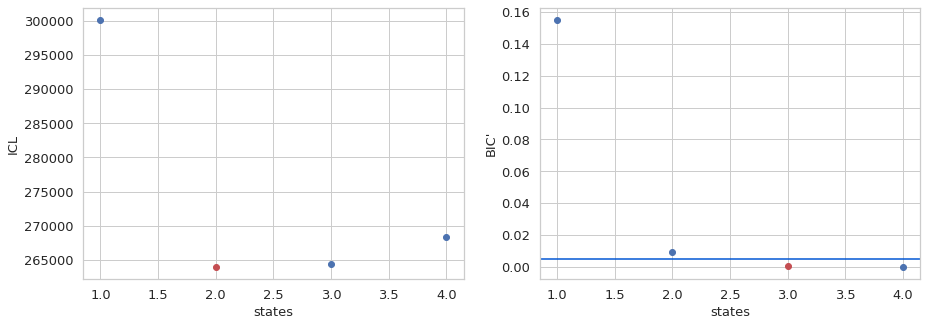

In [40]:
h_da2_beg_time = time.perf_counter()

spdata_da = bhm.BurstData(d_da, ph_streams=[frb.Ph_sel(Dex='Dem'), frb.Ph_sel(Dex='Aem')])

spdata_da.models.calc_models(models=h_modi_2)

h_da2_end_time = time.perf_counter()

printtime(h_da2_beg_time, h_da2_end_time,
          f'Donor active spH2MM optimization for 1 to {spdata_da.models.num_opt} states took: ')

# now an automatic plotting script so we can compare ICL and BIC' values
fig, ax = plt.subplots(1,2,figsize=(15,5))
spdata_da.models.find_ideal('ICL', auto_set=True)
bhm.ICL_plot(spdata_da.models, highlight_ideal=True, ax=ax[0])
spdata_da.models.find_ideal('BICp', thresh=bicp_min, auto_set=True)
bhm.BICp_plot(spdata_da.models, highlight_ideal=True, ax=ax[1])
ax[1].axhline(bicp_min)
spdata_da.models.find_ideal('ICL', auto_set=True)

Based on the ICL, the 2 state model is the best, while BIC' predicts the 3 state model.
Generally ICL is a better measure, however, it does favor slower transition rates, so both models should be considered.

We will also estimate the uncertaintees for all parameters via the https://bursth2mm.readthedocs.io/en/latest/#notebooks/Uncertainty.htmlbootstraperr and https://bursth2mm.readthedocs.io/en/latest/#notebooks/Uncertainty.htmlloglikerr methods for this model specifically.

In [41]:
# Estimate uncertainty values
spdata_da.models[1].bootstrap_eval()
spdata_da.models[1].loglik_err.all_eval()
# Generate res frame
spresframe2_da = spdata_da.models[1].stats_frame(ph_min=5)
# returns frame with paired down values but with conditional transition rate highlighting
spdata_da.models[1].pd_disp(ph_min=5)

The model converged after 115 iterations

The model converged after 107 iterations

The model converged after 108 iterations

The model converged after 114 iterations

The model converged after 104 iterations

The model converged after 108 iterations

The model converged after 120 iterations

The model converged after 121 iterations

The model converged after 101 iterations

The model converged after 114 iterations

,E_raw,to_state_0,to_state_1
state_0,0.638387,19999635.132181,364.867819
state_1,0.111332,122.816848,19999877.183152


The cell bellow shows the 3 state model, as selected by BIC'

In [42]:
spresframe3_da = spdata_da.models[2].stats_frame(ph_min=5)
# returns frame with paired down values but with conditional transition rate highlighting
spdata_da.models[2].pd_disp(ph_min=5)

,E_raw,to_state_0,to_state_1,to_state_2
state_0,0.186598,19999705.015919,215.356675,79.627406
state_1,0.675948,393.831348,19999589.347202,16.821451
state_2,0.071745,92.246162,4.471506,19999903.282332


<a id='mph2mm_da'></a>
#### mpH<sup>2</sup>MM of Donor Active population

The model converged after 2 iterations

The model converged after 63 iterations

The model converged after 62 iterations

The model converged after 124 iterations

The model converged after 1057 iterations

Donor active mpH2MM optimization for 1 to 5 states took:  0h 3m 57.9694s to run


3

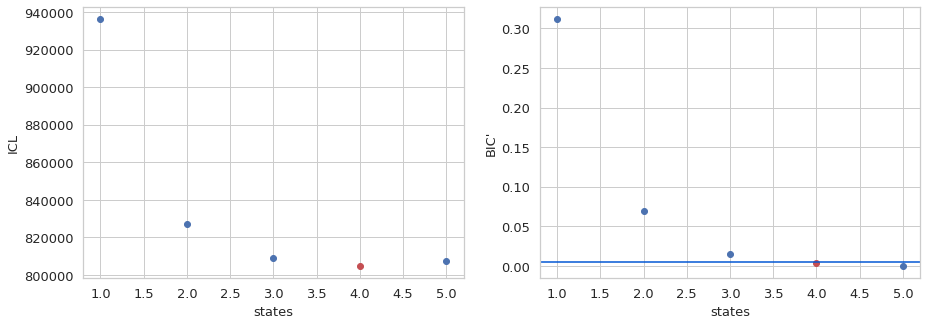

In [43]:
h_da3_beg_time = time.perf_counter()

mpdata_da = bhm.BurstData(d_da)

mpdata_da.models.calc_models(models=h_modi_3)

h_da3_end_time = time.perf_counter()
printtime(h_da3_beg_time, h_da3_end_time,
          f'Donor active mpH2MM optimization for 1 to {mpdata_da.models.num_opt} states took: ')

# now an automatic plotting script so we can compare ICL and BIC' values
fig, ax = plt.subplots(1,2,figsize=(15,5))
mpdata_da.models.find_ideal('ICL', auto_set=True)
bhm.ICL_plot(mpdata_da.models, highlight_ideal=True, ax=ax[0])
mpdata_da.models.find_ideal('BICp', thresh=bicp_min, auto_set=True)
bhm.BICp_plot(mpdata_da.models, highlight_ideal=True, ax=ax[1])
ax[1].axhline(bicp_min)
mpdata_da.models.find_ideal('ICL', auto_set=True)

Based on the ICL, the 4 state model is the best descriptor of the data for the mpH<sup>2</sup>MM data. This is inconsistent with the spH<sup>2</sup>MM. How are the models different? What did the additional photon stream allow the algorithm to find?

In [44]:
# Estimate uncertainty values
mpdata_da.models[3].bootstrap_eval()
mpdata_da.models[3].loglik_err.all_eval()
# Generate res frame
mpresframe_da = mpdata_da.models[3].stats_frame(ph_min=5)
# returns frame with paired down values but with conditional transition rate highlighting
mpdata_da.models[3].pd_disp(ph_min=5)

The model converged after 229 iterations

The model converged after 298 iterations

The model converged after 378 iterations

The model converged after 200 iterations

The model converged after 214 iterations

The model converged after 722 iterations

The model converged after 1011 iterations

The model converged after 473 iterations

The model converged after 230 iterations

The model converged after 269 iterations

,E_raw,S_raw,to_state_0,to_state_1,to_state_2,to_state_3
state_0,0.665864,0.455769,19999622.018987,30.229358,333.005670,14.745985
state_1,0.455884,0.155787,80.245895,19999032.655269,700.926605,186.172231
state_2,0.164601,0.554644,163.469692,136.134640,19999594.178076,106.217593
state_3,0.069756,0.964112,9.624472,45.721802,146.834215,19999797.819511


<a id='fret_h2mm'></a>
### FRET H<sup>2</sup>MM analysis
<a id='1p_fret_h2mm'></a>
#### 1 Parameter Traditional H<sup>2</sup>MM of FRET population

The model converged after 2 iterations

The model converged after 116 iterations

The model converged after 2720 iterations

Optimization reached maximum number of iterations

FRET spH2MM optimization for 1 to 4 states took:  0h 7m 6.8324s to run


1

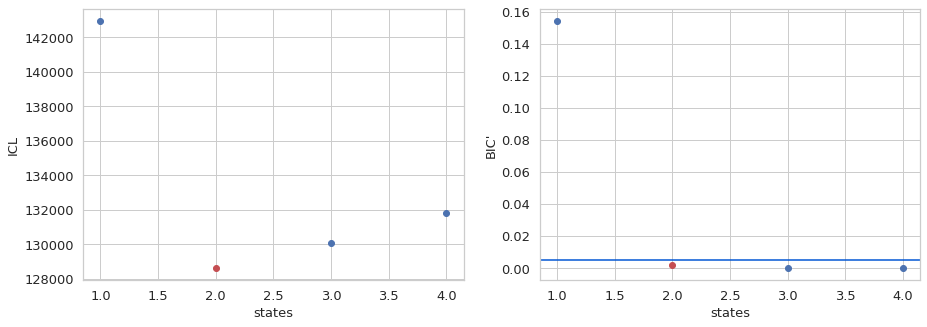

In [45]:
h_fret2_beg_time = time.perf_counter()

spdata_fret = bhm.BurstData(d_fret, ph_streams=[frb.Ph_sel(Dex='Dem'), frb.Ph_sel(Dex='Aem')])

spdata_fret.models.calc_models(models=h_modi_2)

h_fret2_end_time = time.perf_counter()
printtime(h_fret2_beg_time, h_fret2_end_time,
          f'FRET spH2MM optimization for 1 to {spdata_fret.models.num_opt} states took: ')

# now an automatic plotting script so we can compare ICL and BIC' values
fig, ax = plt.subplots(1,2,figsize=(15,5))
spdata_fret.models.find_ideal('ICL', auto_set=True)
bhm.ICL_plot(spdata_fret.models, ax=ax[0], highlight_ideal=True)
spdata_fret.models.find_ideal('BICp', thresh=bicp_min, auto_set=True)
bhm.BICp_plot(spdata_fret.models, highlight_ideal=True)
ax[1].axhline(bicp_min)
spdata_fret.models.find_ideal('ICL', auto_set=True)

For the DCBS search, both ICL and BIC' predict a 2 state model in spH<sup>2</sup>MM 

In [46]:
# Estimate uncertainty values
spdata_fret.models[1].bootstrap_eval()
spdata_fret.models[1].loglik_err.all_eval()
# Generate res frame
spresframe_fret = spdata_fret.models[3].stats_frame(ph_min=5)
# returns frame with paired down values but with conditional transition rate highlighting
spdata_fret.models[1].pd_disp(ph_min=5)

The model converged after 140 iterations

The model converged after 145 iterations

The model converged after 150 iterations

The model converged after 144 iterations

The model converged after 140 iterations

The model converged after 140 iterations

The model converged after 138 iterations

The model converged after 148 iterations

The model converged after 144 iterations

The model converged after 142 iterations

/home/paul/anaconda3/envs/testenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paul/anaconda3/envs/testenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,E_raw,to_state_0,to_state_1
state_0,0.674143,19999605.019585,394.980415
state_1,0.163441,179.720877,19999820.279123


<a id='2p_fret_h2mm'></a>
#### 2 Parameter H<sup>2</sup>MM of FRET population

The model converged after 4 iterations

The model converged after 123 iterations

The model converged after 1276 iterations

The model converged after 704 iterations

FRET mpH2MM optimization for 1 to 4 states took:  0h 1m 32.5606s to run


1

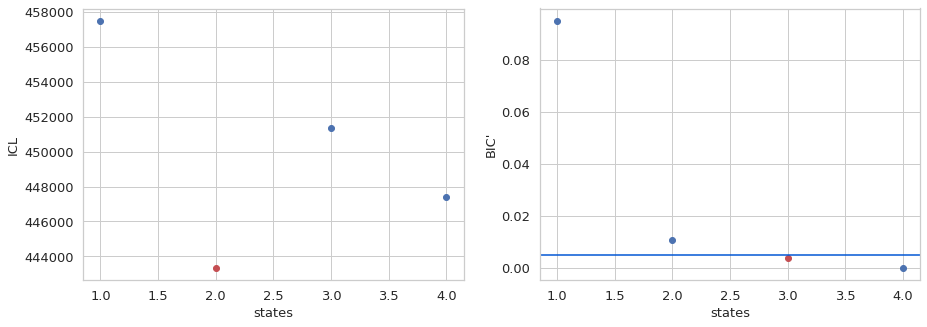

In [47]:
h_fret3_beg_time = time.perf_counter()

mpdata_fret = bhm.BurstData(d_fret)

mpdata_fret.models.calc_models(models=h_modi_3)

h_fret3_end_time = time.perf_counter()
printtime(h_fret3_beg_time, h_fret3_end_time,
          f'FRET mpH2MM optimization for 1 to {mpdata_fret.models.num_opt} states took: ')

# now an automatic plotting script so we can compare ICL and BIC' values
fig, ax = plt.subplots(1,2,figsize=(15,5))
mpdata_fret.models.find_ideal('ICL', auto_set=True)
bhm.ICL_plot(mpdata_fret.models, highlight_ideal=True, ax=ax[0])
mpdata_fret.models.find_ideal('BICp', thresh=bicp_min, auto_set=True)
bhm.BICp_plot(mpdata_fret.models, highlight_ideal=True, ax=ax[1])
ax[1].axhline(bicp_min)
mpdata_fret.models.find_ideal('ICL', auto_set=True)

Based on the $ICL$, the 2 state model is the best descriptor of the data for the mpH<sup>2</sup>MM data. Unlike with the Donor Active selection, both spH<sup>2</sup>MM and mpH<sup>2</sup>MM $ICL$ prediction agree. However, $S_{raw}$ values are directly computed from the model. Also, note that the $BIC'$ prediction from spH<sup>2</sup>MM and mpH<sup>2</sup>MM now disagree, with mpH<sup>2</sup>MM predicting a 3 state model. Different Burst selections therefore influence the states found. By removing the Donor Active bursts with DCBS, there is no longer a significant enough proportion of these bursts or states for mpH<sup>2</sup>MM to detect, thus removing that state from the ideal selection.

In the MalE notebooks however, it is noteable that there significant enough blinking, that the Donor Active state is still resolved with mpH<sup>2</sup>MM, even with a DCBS selection.

In [48]:
# Estimate uncertainty values
mpdata_fret.models[1].bootstrap_eval()
mpdata_fret.models[1].loglik_err.all_eval()
# Generate res frame
mpresframe_fret = mpdata_fret.models[2].stats_frame(ph_min=5)
# returns frame with paired down values but with conditional transition rate highlighting
mpdata_fret.models[1].pd_disp(ph_min=5)

The model converged after 159 iterations

The model converged after 157 iterations

The model converged after 158 iterations

The model converged after 156 iterations

The model converged after 141 iterations

The model converged after 155 iterations

The model converged after 154 iterations

The model converged after 164 iterations

The model converged after 139 iterations

The model converged after 152 iterations

,E_raw,S_raw,to_state_0,to_state_1
state_0,0.668430,0.441881,19999564.221429,435.778571
state_1,0.159621,0.546045,225.723177,19999774.276823


By comparing the 2 and 3 state models, it is clear that two of the mpH<sup>2</sup>MM states match those found with spH<sup>2</sup>MM, and both have $S_{raw}$s close to 0.5, while the third state has a high $S_{raw}$, indicating that with the addition of the A<sub>ex</sub>A<sub>em</sub> stream, acceptor blinking is detectable. Note also that transition rates remain consistent between 2 and 3 state models.

Therefore resutls from both will lead to similar interpretations of the data, but *Viterbi* analysis will be more reliable with a 2 state model, as ICL is based on *Viterbi* fits, and therefore dwells in the acceptor blinked state from a 3 state *Viterbi* analysis will be more dubious as to their beginning and end.

Now that the state model have been chosen let's calculate the error:

Before we go, let's see how long the entire process has take so far:

In [49]:
h2mm_time = time.perf_counter()
printtime(begin,h2mm_time,'The entire analysis up to this point has taken: ')

The entire analysis up to this point has taken:  0h 23m 26.0846s to run


<a id='examineresults'></a>
## Plotting results

Now that we have run the optimizations, we can now plot and compare the different models.

But first, while **burstH2MM** does a good job with most of the plotting, as we will be making compound figures, here are some functions and color definitions that we will use in this particular notebook to help coordinate things.

In [50]:
# a 9 color, color-blind friendly color map (or at least so I'm told)
clr = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

# converts a tuple of states into their binary representation in H2MM_result.burst_type
st_bin = lambda nums: sum(2**n for n in nums)

################################################
# Functions for organizing/generate state labels
################################################


def comb_label(nums, labels):
    """
    Generate a label from a tuple of states and a list of state-names
    
    Parameters
    ----------
    nums : array-like[int]
        A tuple of which states (in order found within the model) to generate the label
    labels : array-like[str]
        A list or tuple of strings, same as number of states in model, giving names
        to each state
    
    Returns
    -------
    label : str
        A string representing the label of the set of states represented in nums
    """
    if len(nums) == 1:
        label = labels[nums[0]]
    elif len(nums) == 2:
        label = ' and '.join(labels[i] for i in nums)
    else:
        label = ', '.join(labels[i] for i in nums[:-1]) + ', and ' + labels[nums[-1]]
    return label

def comb_level(n, m):
    """
    For burst_type labels, return a list of length n specifying,
    with m colors if for a given number of states present
    0: All states can be named separately
    1: Can only identify how many states present
    2: Identify only as "dynamics"
    
    Parameters
    ----------
    n : int
        number of states in model
    m : int
        number of colors available
    
    Returns
    level : list[int]
        How states can be defined with given set of colors
        0: All states can be named separately
        1: Can only identify how many states present
        2: Identify only as "dynamics"
    
    """
    i, l = 0, 0
    level = [2 for _ in range(n)]
    while i < n:
        i += 1
        combs = comb(n, i)
        if l + combs < m:
            l += combs
            level[i-1] = 0
        else:
            j = 1 if m - l >= n else 2
            level[i-1:] =  [j for _ in range(n - i+1)]
            break
    return level

def burst_color_comb(labels, colors):
    """
    Generate list of keyword arguments for burst_kwargs of burst_ES_scatter()
    
    Parameters
    ----------
    labels : list[str]
        list of state names for model
    colors : list[color definition]
        list of color definitions
    
    Returns
    -------
    burst_out : list[dict]
        Keyword arguments in correct order for burst_ES_scatter()
    order : list[int]
        order in which to organize legend elements
    """
    lbln, clln = len(labels), len(colors)
    possible = comb_level(lbln, clln)
    out = list()
    c = 0
    n = 0
    for i in range(lbln):
        for lbls in combinations(range(lbln), i+1):
            level = st_bin(lbls)
            color = colors[c]
            if possible[i] == 0:
                label = comb_label(lbls, labels)
                c += 1
            elif possible[i] == 1:
                label = f'{i+1} states'
            else:
                label = 'Dynamics'
            out.append((level, {'label':label, 'c':color}, n))
            n += 1
        if possible == 1:
            c += 1
    sort_out = [(val, n) for level, val, n in sorted(out)]
    burst_out = [val for val, n in sort_out]
    order = [n for val, n in sort_out]
    return burst_out, order


##############################################################
# Aditional dictionaries matching streams to labels and colors
##############################################################

# Define color for each photon stream in plot_burst_index
stream_color = {frb.Ph_sel(Dex='Dem'):'g', 
                frb.Ph_sel(Dex='Aem'):'r', 
                frb.Ph_sel(Aex='Aem'):'purple'}

# label for each photon stream, using latex for subscripts
stream_label = {frb.Ph_sel(Dex='Dem'):r'$D_{ex}D_{em}$', 
          frb.Ph_sel(Dex='Aem'):r'$D_{ex}A_{em}$', 
          frb.Ph_sel(Aex='Aem'):r'$A_{ex}A_{em}$'}

def st_kw(state, data):
    """
    Generate list of keyword arguments to identify photon stream for a given state in 
    state_nanotime_hist()
    
    Parameters
    ----------
    state : str
        Name of state
    data : H2MM_result, H2MM_lsit, BurstData
        The reference data object
    
    Returns
    -------
    list[dict]
        list of keyword arguments giving color and label for each photon stream
        """
    if isinstance(data, bhm.H2MM_result):
        data = data.parent.parent
    elif isinstance(data, bhm.H2MM_list):
        data = data.parent
    elif not isinstance(data, bhm.BurstData):
        raise TypeError("data must be BurstData, H2MM_list or H2MM_result")
    return [{'c':stream_color[stream], 'label':f'{state} {stream_label[stream]}'} for stream in data.ph_streams]

<a id='da_result'></a>
### Donor Active Burst Selection

Before we begin, we want to know the order of states within the model, so we can give them appropriate names.

So we will plot them, adn add in a list that gives colors and a numerical label to each, so we can match the state with the color in the legend, and thus know which number it is in the model.

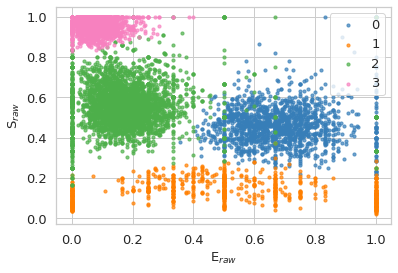

In [51]:
mpdata = mpdata_da
bhm.dwell_ES_scatter(mpdata.models, state_kwargs=[{'label':f'{i}', 'c':clr[i]} 
                                                  for i in range(mpdata.models.ideal+1)])
plt.legend()

And from that we can define a list of strings that appropriately names the states.

> **Note**
>
> This list will be used to generate labels in plots.
> Therefore to make sure labels fit, somewhat shortened names are used.

In [52]:
state_names_da = ['Closed','dark D','Open', 'dark A']

<a id='mainplot_da'></a>
#### Summary plots

 - Computing histogram.


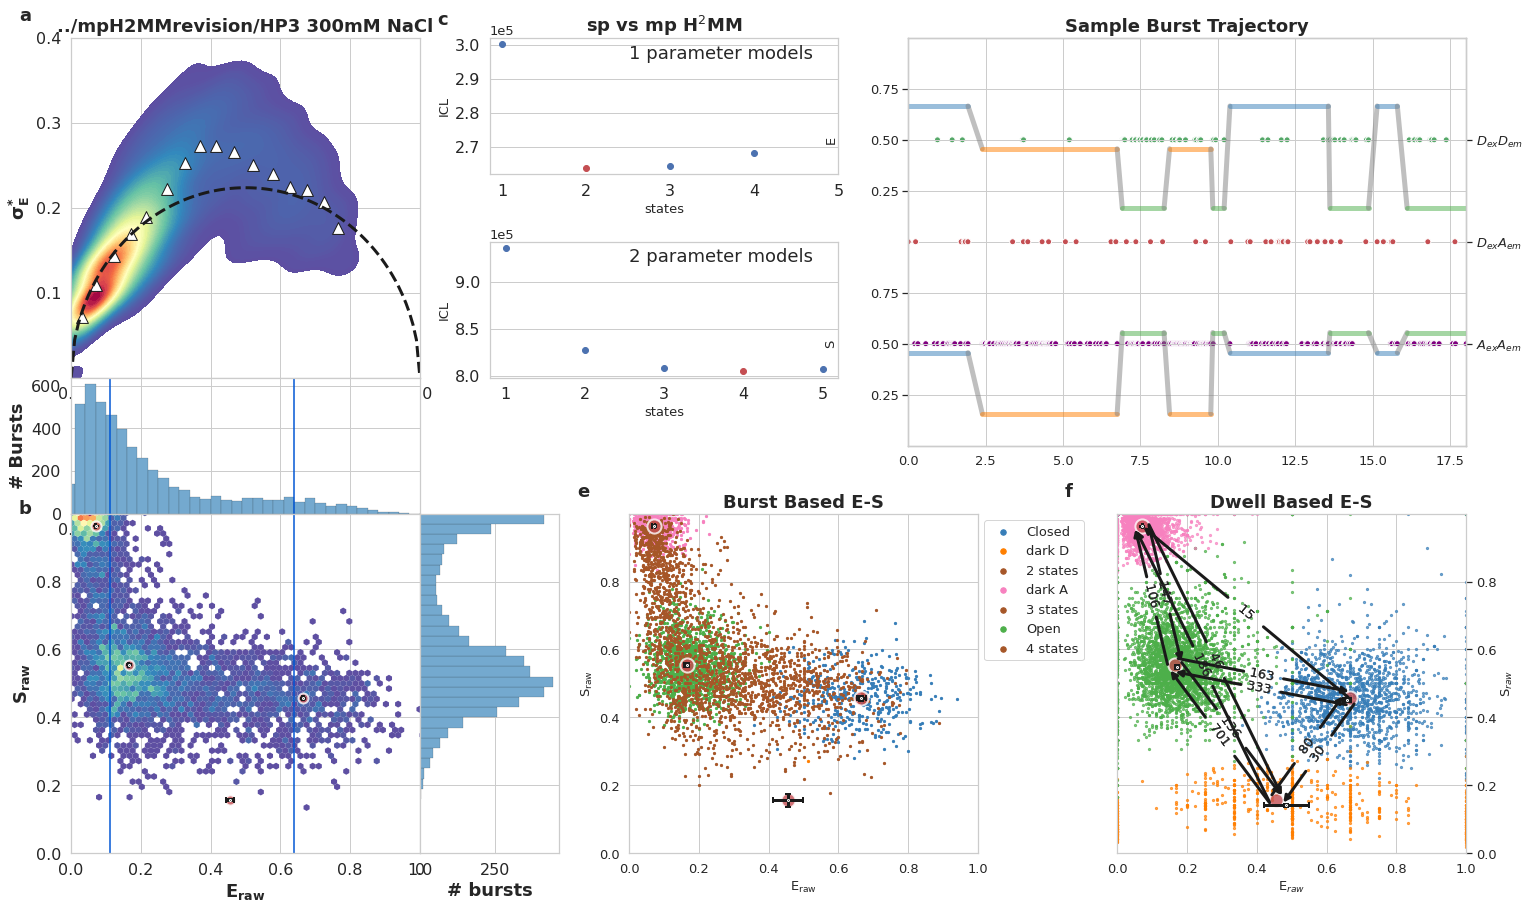

In [53]:
#########################################################################
# Function like inputs, so cell can be coppied and only lines at the top
# need to be changed
data = d_da
spdata = spdata_da
mpdata = mpdata_da

# Non data settings
state_names = state_names_da
fname = filename.split('.hdf5')[0]
plot_sel = 'Donor Active'
fplot_sel = 'DA'
burst_marker_size = 5
plot_t = plot_title
# End of function-like inputs
#########################################################################
        
# set up the figures subplots
fig1 = plt.figure(figsize=(25,15))
gs1 = gridspec.GridSpec(nrows=12,ncols=20,figure=fig1)
plt.subplots_adjust(hspace=0, wspace=0)
ax1 = []
ax1.append(fig1.add_subplot(gs1[0:5,0:5])) # BVA plot ax1[0]
ax1.append(fig1.add_subplot(gs1[5:7,0:5],sharex=ax1[0])) # 1D FRET histogram ax1[1]
ax1.append(fig1.add_subplot(gs1[7:12,0:5],sharex=ax1[0])) # ES hexbin plot ax1[2]
ax1.append(fig1.add_subplot(gs1[7:12:,5:7],sharey=ax1[2])) # S histogram ax1[3]
ax1.append(fig1.add_subplot(gs1[0:2,6:11])) # 1pH2MM BIC' ax1[4]
ax1.append(fig1.add_subplot(gs1[3:5,6:11])) # 2pH2MM BIC' ax1[5]
ax1.append(fig1.add_subplot(gs1[0:6,12:20])) # E photon path ax1[6]
ax1.append(fig1.add_subplot(gs1[7:12,8:13], sharey=ax1[2], sharex=ax1[2])) # Burst based E-S viterbi calssification ax1[7]
ax1.append(fig1.add_subplot(gs1[7:12,15:20],sharey=ax1[7],sharex=ax1[7])) # Dwell based E-S viterbi classification ax1[8]

# plotting the BVA plot
E_fret, std_fret = BVA(data, n)
E_fret_bin, std_fret_bin = bin_bva(E_fret, std_fret, R, B_Thr)
E_fret, std_fret = np.concatenate(E_fret), np.concatenate(std_fret)
im = sns.kdeplot(x=E_fret, y=std_fret,shade=True, cmap='Spectral_r', n_levels=plot_levels, 
                 thresh=0.05, gridsize=100, ax=ax1[0])
ax1[0].scatter(E_fret_bin, std_fret_bin, marker='^',s=140,color='white',edgecolors='k',alpha=1)
ax1[0].set_ylim([0,0.4])
x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
ax1[0].plot(x_T,y_T, lw=3, color='k', ls='--')
ax1[0].set_ylabel('$\mathbf{\sigma_{E}^{*}}$',fontsize=18)

# plotting the E and S histograms that surround the ES hexbin plot
frb.dplot(data, frb.hist_fret, ax=ax1[1], pdf=False, weights=None, verbose=True)
frb.dplot(data, frb.hist_burst_data, data_name='S', ax=ax1[3], vertical=True)
frb.dplot(data, frb.hexbin_alex, ax=ax1[2])
bhm.scatter_ES(mpdata.models,  color='r',marker='o', s=100, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='loglik')
bhm.axline_E(spdata.models, ax=ax1[1])
bhm.axline_E(spdata.models, ax=ax1[2])

# set limits and labels on first column 
ax1[0].set_yticks(np.arange(0.1,0.5,0.1))
ax1[1].set_ylabel('# Bursts',fontsize=18,fontweight='bold')
ax1[2].set_xlabel('$\mathbf{E_{raw}}$',fontsize=18,)
ax1[2].set_ylabel('$\mathbf{S_{raw}}$',fontsize=18)
ax1[2].set_yticks([0,0.2,0.4,0.6,0.8])
ax1[0].set_xlim([0,1])
ax1[0].set_title(plot_title,fontsize=18,fontweight='bold')
ax1[0].tick_params(labelsize=16)
ax1[1].tick_params(labelsize=16)
ax1[2].tick_params(labelsize=16)
ax1[3].tick_params(labelsize=16)
ax1[2].set_ylim([0,1])
ax1[0].text(-0.15,1.05,'a',fontsize=18,fontweight='bold',transform=ax1[0].transAxes)
ax1[1].set_title(' ')
ax1[2].set_title(' ')
ax1[2].text(-0.15,1.0,'b',fontsize=18,fontweight='bold',transform=ax1[2].transAxes)
ax1[3].set_title(' ')
ax1[3].set_ylabel(' ')
ax1[3].set_xlabel('# bursts',fontsize=18,fontweight='bold')
plt.setp(ax1[3].get_yticklabels(), visible=False)

# ICL plots
bhm.ICL_plot(spdata.models, highlight_ideal=True, ax=ax1[4])
bhm.ICL_plot(mpdata.models, highlight_ideal=True, ax=ax1[5])
ax1[4].grid(axis='x')
ax1[4].set_xticks(np.arange(1, max([spdata.models.max_opt, mpdata.models.max_opt])+1))
ax1[4].tick_params(labelsize=16)
ax1[4].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax1[4].annotate('1 parameter models',(0.4,0.85),xycoords='axes fraction',fontsize=18)
ax1[4].set_title("sp vs mp H$^2$MM",fontsize=18,fontweight='bold')
ax1[4].text(-0.15,1.1,'c',fontsize=18,fontweight='bold',transform=ax1[4].transAxes)
ax1[5].grid(axis='x')
ax1[5].set_xticks(np.arange(1, max([spdata.models.max_opt, mpdata.models.max_opt])+1))
ax1[5].tick_params(labelsize=16)
ax1[5].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax1[5].annotate('2 parameter models',(0.4,0.85),xycoords='axes fraction',fontsize=18)

# set up names for burst and dwell-based plots
burst_kwargs, order = burst_color_comb(state_names, clr)
state_kwargs = [burst_kwargs[(2**i)-1] for i in range(len(state_names))]
path_state_color = [sk['c'] for sk in state_kwargs]


# # plot photon path
bhm.plot_burstjoin(mpdata.models[mpdata.models.ideal], 'transitions', ax=ax1[6], 
                   state_color=path_state_color, path_kwargs={'linewidth':5, 'alpha':0.5})
ax1[6].set_title('Sample Burst Trajectory',fontsize=18,fontweight='bold')



collections = bhm.burst_ES_scatter(mpdata, ax=ax1[7], s=burst_marker_size, type_kwargs=burst_kwargs)
bhm.scatter_ES(mpdata, ax=ax1[7], color='r',marker='o', s=200, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='bootstrap_std')
# sort labels by number of states
labels = [collections[i].get_label() for i in order]
collections_order = [collections[i] for i in order]
# isolate unique labels
unique = [i for i, label in enumerate(labels) if label not in labels[:i]]
# trim labels down
labels = [labels[i] for i in unique]
handles = [collections_order[i] for i in unique]

legend = ax1[7].legend(handles, labels, bbox_to_anchor=(1.0,1.0))
for leg in legend.legendHandles:
    leg.set_sizes([30.0])

ax1[7].set_title('Burst Based E-S',fontsize=18,fontweight='bold')
ax1[7].text(-0.15,1.05,'e',fontsize=18, fontweight='bold',transform=ax1[7].transAxes)
# ax1[7].set_xlabel('$\mathbf{E_{raw}}$',fontsize=18)
# ax1[7].set_ylabel('$\mathbf{S_{raw}}$',fontsize=18)
# ax1[7].legend(bbox_to_anchor=(1.0, 1.0))

bhm.dwell_ES_scatter(mpdata.models, ax=ax1[8], s=burst_marker_size, state_kwargs=state_kwargs)
bhm.scatter_ES(mpdata.models, ax=ax1[8], color='r',marker='o', s=200, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='viterbi_std')
bhm.trans_arrow_ES(mpdata.models, ax=ax1[8], arrowprops=dict(linewidth=3))
ax1[8].set_title('Dwell Based E-S',fontsize=18,fontweight='bold')
ax1[8].text(-0.15,1.05,'f',fontsize=18, fontweight='bold',transform=ax1[8].transAxes)
# ax1[8].set_xlabel('$\mathbf{E_{raw}}$',fontsize=18)
# ax1[8].set_ylabel('$\mathbf{S_{raw}}$',fontsize=18)
ax1[8].yaxis.set_ticks_position("right")
ax1[8].yaxis.set_label_position("right")
# fig1.savefig('figures/'+fname+fplot_sel+'_summary_type0.pdf',format='pdf',bbox_inches='tight')

*Write your caption in this cell, below is sample caption.*
*Frames should stay the same, so you can use it as a template*

**mpH<sup>2</sup>MM results for DNA hairpin at 300 mM NaCl, Donor Active burst selection.** 
a) Burst variance analysis (BVA), the standard deviation of $E_{raw}$ values of bursts is displayed versus their $E_{raw}$ values. Bursts with standard deviations higher than expected solely from shot noise (semicircle), are ones that include dynamic heterogeneity, such as within-burst FRET dynamics. 
Triangles indicate the average of standard deviation values per $E_{raw}$ bin. 
b) 2D histogram of $E_{raw}$ and $S_{raw}$ (E-S plots, colloquially) of bursts. 
The $E_{raw}$ and $S_{raw}$ values of sub-populations derived from mpH<sup>2</sup>MM are marked by red circles, and the standard deviation (SD) of these values, derived from the *Viterbi* dwell time analysis, are marked by black crosses. 
Vertical blue bars indicated $E_{raw}$ derived from spH<sup>2</sup>MM. 
c) Comparison of values of the integrated complete likelihood ($ICL$) of spH<sup>2</sup>MM (top panel) and mpH<sup>2</sup>MM (bottom panel) of optimized models with different numbers of states. 
The ideal state-model is marked in red. 
d) Comparison of values of the modified Bayesian Information Criterion ($BIC'$) of optimized models with different numbers of states, using spH<sup>2</sup>MM (top pannel) and mpH<sup>2</sup>MM (bottom pannel), the model with the fewest number of states with a BIC' less than 0.005 is marked in red. 
e) A sample burst trajectory, with photons represented as colored vertical bars, with donor excitation photons colored green or red for donor and acceptor, respectively, and acceptor excitation photons colored purple. $E_{raw}$ (top panel) and $S_{raw}$ (bottom panel) of sub-populations determined from dwells using the *Viterbi* algorithm, are overlayed on the photon bars. 
e,f) E-S scatter plots of data processed by the *Viterbi* algorithm. mpH<sup>2</sup>MM sub-populations and *Viterbi* -derived standard deviations (SD) are overlayed as red circles and black crosses, respectively.

Text(0.5, 1.0, 'Sample Burst Trajectories')

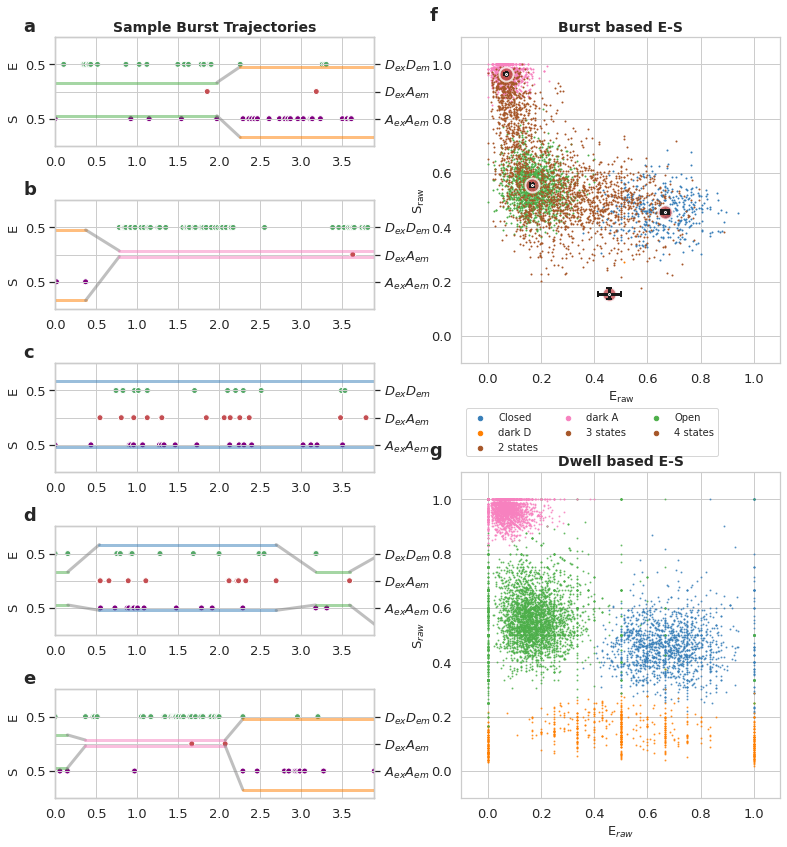

In [54]:
#########################################################################
# Function like inputs, so cell can be coppied and only lines at the top
# need to be changed
mpdata = mpdata_da
state_names = state_names_da
bursts = [200+i for i in range(5)]
fname = filename.split('.hdf5')[0]
fplot_sel = 'DA'
# End of function-like inputs
#########################################################################

assert len(bursts) == 5

# build axes
fig = plt.figure(figsize=(13,14))
gs = gridspec.GridSpec(nrows=14,ncols=13,figure=fig)
plt.subplots_adjust(hspace=0.0, wspace=1)
axt = list()
for i in range(5):
    ax = fig.add_subplot(gs[(3*i):(3*i+2),0:6], sharex=axt[0] if i != 0 else None)
    ax.text(-0.1,1.05,chr(ord('a')+i),fontsize=18,fontweight='bold',transform=ax.transAxes)
    axt.append(ax)
axs = [fig.add_subplot(gs[0:6,7:13]),]
axs.append(fig.add_subplot(gs[8:14,7:13], sharex=axs[0], sharey=axs[0]))

# build arguments for burst and dwell plots
burst_kwargs, order = burst_color_comb(state_names, clr)
state_kwargs = [burst_kwargs[(2**i)-1] for i in range(len(state_names))]
path_state_color = [sk['c'] for sk in state_kwargs]

collections = bhm.burst_ES_scatter(mpdata, ax=axs[0], s=1, type_kwargs=burst_kwargs)
bhm.scatter_ES(mpdata, ax=axs[0], color='r',marker='o', s=200, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='bootstrap_std')
# sort labels by number of states
labels = [collections[i].get_label() for i in order]
collections_order = [collections[i] for i in order]
# isolate unique labels
unique = [i for i, label in enumerate(labels) if label not in labels[:i]]
# trim labels down
labels = [labels[i] for i in unique]
handles = [collections_order[i] for i in unique]

legend = axs[0].legend(handles, labels, title="",loc='lower left',bbox_to_anchor=(0.0,-0.3),fontsize=10,ncol=3)
for leg in legend.legendHandles:
    leg.set_sizes([20.0])

bhm.dwell_ES_scatter(mpdata, ax=axs[1], s=1, state_kwargs=state_kwargs)


axs[0].text(-0.1,1.05,'f',fontsize=18,fontweight='bold',transform=axs[0].transAxes)
axs[0].set_title("Burst based E-S",fontsize=14,fontweight='bold')

axs[1].set_xlim([-0.1,1.1])
axs[1].set_ylim([-0.1,1.1])
axs[0].text(-0.1,1.05,'g',fontsize=18,fontweight='bold',transform=axs[1].transAxes)
axs[1].set_title("Dwell based E-S",fontsize=14,fontweight='bold')


for i, b in enumerate(bursts):
    bhm.plot_burstjoin(mpdata.models, b, ax=axt[i], state_color=path_state_color, 
                       path_kwargs={'linewidth':3, 'alpha':0.5})
    
axt[0].set_title('Sample Burst Trajectories',fontsize=14,fontweight='bold')
# fig.savefig('figures/'+fname+fplot_sel+'_viterbi.pdf',format='pdf',bbox_inches='tight')

*Write your caption in this cell, below is sample caption.*
*Frames should stay the same, so you can use it as a template*

**mpH<sup>2</sup>MM *Viterbi* analysis of DNA haripin at 300mM NaCl Donor Active burst selection** 
a-e) Selected photon traces with the *Viterbi* derived most likely state paths overlayed. Photons are represented as verticle bars colored according to the photon stream, (green for D<sub>ex</sub>D<sub>em</sub> photons, red for D<sub>ex</sub>A<sub>em</sub> photons, and purple for A<sub>ex</sub>A<sub>em</sub> photons). 
Horizontal line represents the $E_{raw}$ (upper pannel) and $S_{raw}$ of the state predicted by the *Viterbi* algorithm. 
e,f) E-S scatter plot of bursts (f) or dwells within bursts (g), color coded by which states are present in the bursts (f) or according to the state of the dwell (g), according to Viterbi algorithm. 
Colors are consistent throughout, with states in a-e colored as in g, and the borders of the burst traces colored as in f.

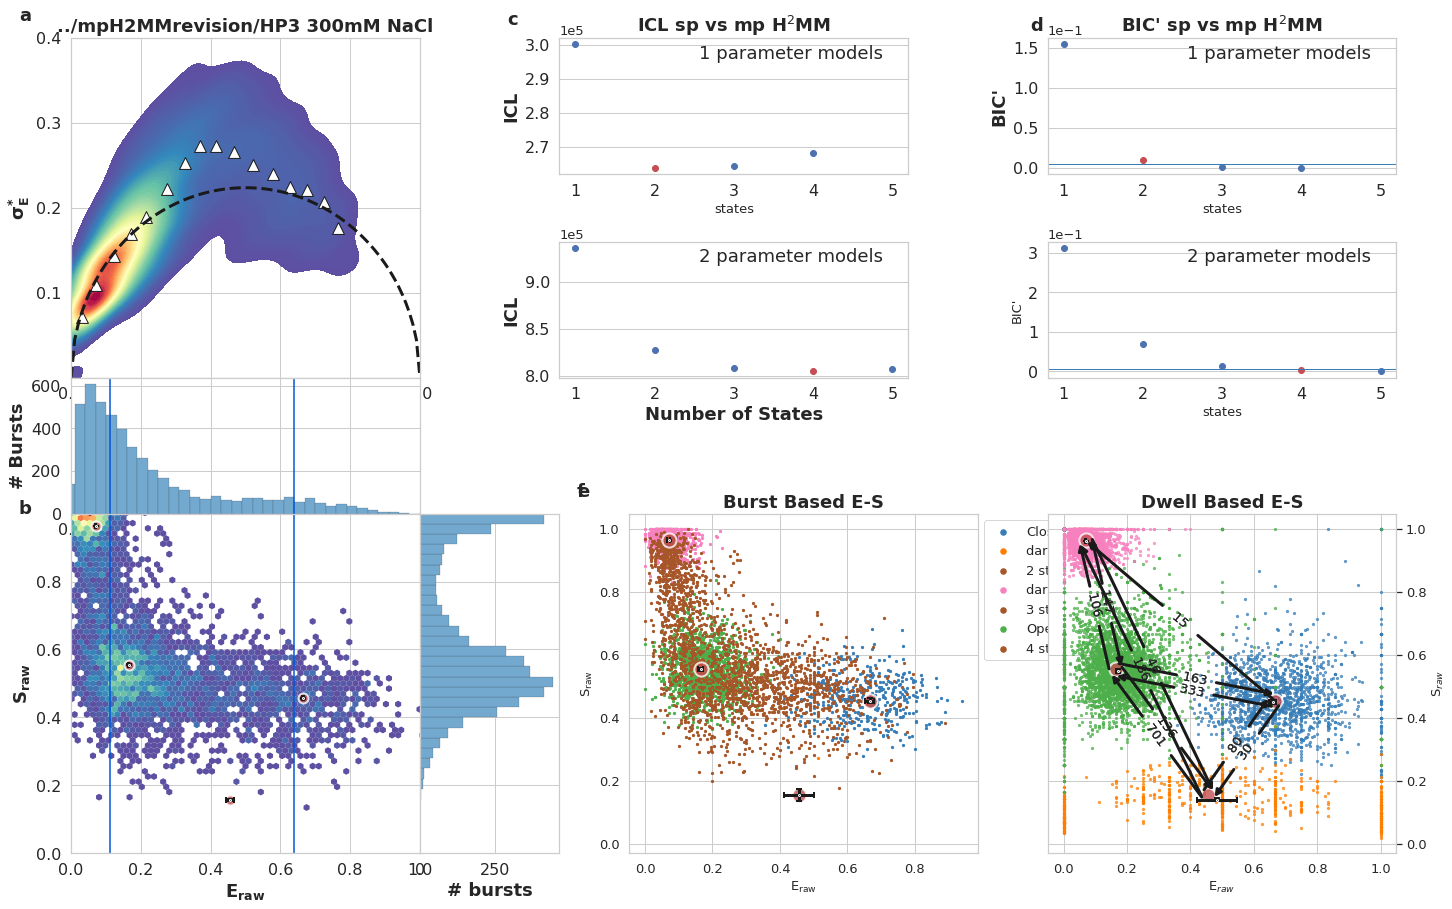

In [55]:
#########################################################################
# Function like inputs, so cell can be coppied and only lines at the top
# need to be changed
data = d_da
spdata = spdata_da
mpdata = mpdata_da
# Non data settings
state_names = state_names_da
fname = filename.split('.hdf5')[0]
plot_sel = 'Donor Active'
fplot_sel = 'DA'
burst_marker_size = 5
barwidth = 0.02
plot_t = plot_title
# End of function-like inputs
#########################################################################


# set up the figures subplots
fig1 = plt.figure(figsize=(25,15))
gs1 = gridspec.GridSpec(nrows=12,ncols=20,figure=fig1)
plt.subplots_adjust(hspace=0, wspace=0)
ax1 = []
ax1.append(fig1.add_subplot(gs1[0:5,0:5])) # BVA plot ax1[0]
ax1.append(fig1.add_subplot(gs1[5:7,0:5],sharex=ax1[0])) # 1D FRET histogram ax1[1]
ax1.append(fig1.add_subplot(gs1[7:12,0:5],sharex=ax1[0])) # ES hexbin plot ax1[2]
ax1.append(fig1.add_subplot(gs1[7:12:,5:7],sharey=ax1[2])) # S histogram ax1[3]
ax1.append(fig1.add_subplot(gs1[0:2,7:12])) # 1pH2MM ICL ax1[4]
ax1.append(fig1.add_subplot(gs1[3:5,7:12],sharex=ax1[4])) # 2pH2MM ICL ax1[5]
ax1.append(fig1.add_subplot(gs1[0:2,14:19])) # 1pH2MM BIC' ax1[6]
ax1.append(fig1.add_subplot(gs1[3:5,14:19],sharex=ax1[6])) # 2pH2MM BIC' ax1[7]
ax1.append(fig1.add_subplot(gs1[7:12,8:13])) # Burst based E-S viterbi calssification ax1[8]
ax1.append(fig1.add_subplot(gs1[7:12,14:19],sharey=ax1[8])) # Dwell based E-S viterbi classification ax1[9]

# plotting the BVA plot
E_fret, std_fret = BVA(data, n)
E_fret_bin, std_fret_bin = bin_bva(E_fret, std_fret, R, B_Thr)
E_fret, std_fret = np.concatenate(E_fret), np.concatenate(std_fret)
im = sns.kdeplot(x=E_fret, y=std_fret,shade=True, cmap='Spectral_r', n_levels=plot_levels, 
                 thresh=0.05, gridsize=100, ax=ax1[0])
ax1[0].scatter(E_fret_bin, std_fret_bin, marker='^',s=140,color='white',edgecolors='k',alpha=1)
ax1[0].set_ylim([0,0.4])
x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
ax1[0].plot(x_T,y_T, lw=3, color='k', ls='--')
ax1[0].set_ylabel('$\mathbf{\sigma_{E}^{*}}$',fontsize=18)

# plotting the E and S histograms that surround the ES hexbin plot
frb.dplot(data, frb.hist_fret, ax=ax1[1], pdf=False, weights=None, verbose=True)
frb.dplot(data, frb.hist_burst_data, data_name='S', ax=ax1[3], vertical=True)
frb.dplot(data, frb.hexbin_alex, ax=ax1[2])
bhm.scatter_ES(mpdata.models,  color='r',marker='o', s=100, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='loglik')
bhm.axline_E(spdata.models, ax=ax1[1])
bhm.axline_E(spdata.models, ax=ax1[2])

# set limits and labels on first column 
ax1[0].set_yticks(np.arange(0.1,0.5,0.1))
ax1[1].set_ylabel('# Bursts',fontsize=18,fontweight='bold')
ax1[2].set_xlabel('$\mathbf{E_{raw}}$',fontsize=18,)
ax1[2].set_ylabel('$\mathbf{S_{raw}}$',fontsize=18)
ax1[2].set_yticks([0,0.2,0.4,0.6,0.8])
ax1[0].set_xlim([0,1])
ax1[0].set_title(plot_title,fontsize=18,fontweight='bold')
ax1[0].tick_params(labelsize=16)
ax1[1].tick_params(labelsize=16)
ax1[2].tick_params(labelsize=16)
ax1[3].tick_params(labelsize=16)
ax1[2].set_ylim([0,1])
ax1[0].text(-0.15,1.05,'a',fontsize=18,fontweight='bold',transform=ax1[0].transAxes)
ax1[1].set_title(' ')
ax1[2].set_title(' ')
ax1[2].text(-0.15,1.0,'b',fontsize=18,fontweight='bold',transform=ax1[2].transAxes)
ax1[3].set_title(' ')
ax1[3].set_ylabel(' ')
ax1[3].set_xlabel('# bursts',fontsize=18,fontweight='bold')
plt.setp(ax1[3].get_yticklabels(), visible=False)

# ICL plots
bhm.ICL_plot(spdata.models, highlight_ideal=True, ax=ax1[4])
bhm.ICL_plot(mpdata.models, highlight_ideal=True, ax=ax1[5])
ax1[4].grid(axis='x')
ax1[4].set_xticks(np.arange(1, max([spdata.models.max_opt, mpdata.models.max_opt])+1))
ax1[4].tick_params(labelsize=16)
ax1[4].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax1[4].annotate('1 parameter models',(0.4,0.85),xycoords='axes fraction',fontsize=18)
ax1[4].set_title("ICL sp vs mp H$^2$MM",fontsize=18,fontweight='bold')
ax1[4].text(-0.15,1.1,'c',fontsize=18,fontweight='bold',transform=ax1[4].transAxes)
ax1[4].set_ylabel("ICL",fontsize=18,fontweight='bold')
ax1[5].grid(axis='x')
ax1[5].set_xticks(np.arange(1, max([spdata.models.max_opt, mpdata.models.max_opt])+1))
ax1[5].tick_params(labelsize=16)
ax1[5].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax1[5].annotate('2 parameter models',(0.4,0.85),xycoords='axes fraction',fontsize=18)
ax1[5].set_ylabel("ICL",fontsize=18,fontweight='bold')
ax1[5].set_xlabel("Number of States",fontsize=18,fontweight='bold')

# plot BIC'
bhm.BICp_plot(spdata.models, ax=ax1[6], highlight_ideal=True)
bhm.BICp_plot(mpdata.models, ax=ax1[7], highlight_ideal=True)
ax1[6].axhline(bicp_min,c=clr[0],ls='-',lw=1)
ax1[7].axhline(bicp_min,c=clr[0],ls='-',lw=1)
ax1[6].grid(axis='x')
ax1[6].set_xticks(np.arange(1, max([spdata.models.max_opt, mpdata.models.max_opt])+1))
ax1[6].tick_params(labelsize=16)
ax1[6].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax1[6].annotate('1 parameter models',(0.4,0.85),xycoords='axes fraction',fontsize=18)
ax1[6].set_title("BIC' sp vs mp H$^2$MM",fontsize=18,fontweight='bold')
ax1[6].text(-0.05,1.05,'d',fontsize=18,fontweight='bold',transform=ax1[6].transAxes)
ax1[6].set_ylabel("BIC'",fontsize=18,fontweight='bold')
ax1[7].grid(axis='x')
ax1[7].set_xticks(np.arange(1, max([spdata.models.max_opt, mpdata.models.max_opt])+1))
ax1[7].tick_params(labelsize=16)
ax1[7].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax1[7].annotate('2 parameter models',(0.4,0.85),xycoords='axes fraction',fontsize=18)
# ax1[7].set_ylabel("ICL",fontsize=18,fontweight='bold')
# ax1[7].set_xlabel("Number of States",fontsize=18,fontweight='bold')



# set up names for burst and dwell-based plots
burst_kwargs, order = burst_color_comb(state_names, clr)

state_kwargs = [burst_kwargs[(2**i)-1] for i in range(len(state_names))]

collections = bhm.burst_ES_scatter(mpdata, ax=ax1[8], s=burst_marker_size, type_kwargs=burst_kwargs)
bhm.scatter_ES(mpdata, ax=ax1[8], color='r',marker='o', s=200, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='bootstrap_std')
# sort labels by number of states
labels = [collections[i].get_label() for i in order]
collections_order = [collections[i] for i in order]
# isolate unique labels
unique = [i for i, label in enumerate(labels) if label not in labels[:i]]
# trim labels down
labels = [labels[i] for i in unique]
handles = [collections_order[i] for i in unique]

legend = ax1[8].legend(handles, labels, bbox_to_anchor=(1.0,1.0))
for leg in legend.legendHandles:
    leg.set_sizes([30.0])

ax1[8].set_title('Burst Based E-S',fontsize=18,fontweight='bold')
ax1[8].text(-0.15,1.05,'e',fontsize=18, fontweight='bold',transform=ax1[8].transAxes)
# ax1[8].set_xlabel('$\mathbf{E_{raw}}$',fontsize=18)
# ax1[8].set_ylabel('$\mathbf{S_{raw}}$',fontsize=18)
# ax1[8].legend(bbox_to_anchor=(1.0, 1.0))

bhm.dwell_ES_scatter(mpdata.models, ax=ax1[9], s=burst_marker_size, state_kwargs=state_kwargs)
bhm.scatter_ES(mpdata.models, ax=ax1[9], color='r',marker='o', s=200, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='viterbi_std')
bhm.trans_arrow_ES(mpdata.models, ax=ax1[9], arrowprops=dict(linewidth=3))
ax1[9].set_title('Dwell Based E-S',fontsize=18,fontweight='bold')
ax1[9].text(-0.15,1.05,'f',fontsize=18, fontweight='bold',transform=ax1[8].transAxes)
# ax1[9].set_xlabel('$\mathbf{E_{raw}}$',fontsize=18)
# ax1[9].set_ylabel('$\mathbf{S_{raw}}$',fontsize=18)
ax1[9].yaxis.set_ticks_position("right")
ax1[9].yaxis.set_label_position("right")
# fig1.savefig('figures/'+fname+fplot_sel+'_summary_type2.pdf',format='pdf',bbox_inches='tight')

*Write your caption in this cell, below is sample caption.*
*Frames should stay the same, so you can use it as a template*

**mpH<sup>2</sup>MM results for DNA hairpin at 300 mM NaCl, Donor Active burst selection.** 
a) Burst variance analysis (BVA), the standard deviation of $E_{raw}$ values of bursts is displayed versus their $E_{raw}$ values. Bursts with standard deviations higher than expected solely from shot noise (semicircle), are ones that include dynamic heterogeneity, such as within-burst FRET dynamics. 
Triangles indicate the average of standard deviation values per $E_{raw}$ bin. 
b) 2D histogram of $E_{raw}$ and $S_{raw}$ (E-S plots, colloquially) of bursts. 
The $E_{raw}$ and $S_{raw}$ values of sub-populations derived from mpH<sup>2</sup>MM are marked by red circles, and the standard deviation (SD) of these values, derived from the *Viterbi* dwell time analysis, are marked by black crosses. Vertical blue bars indicated $E_{raw}$ derived from spH<sup>2</sup>MM. 
c) Comparison of values of the integrated complete likelihood ($ICL$) of spH<sup>2</sup>MM (top panel) and mpH<sup>2</sup>MM (bottom panel) of optimized models with different numbers of states. The ideal state-model is marked in red. 
d) Comparison of values of the modified Bayesian Information Criterion ($BIC'$) for spH<sup>2</sup>MM (top pannel) and mpH<sup>2</sup>MM of optimized models with different numbers of states. 
e,f) E-S scatter plots of data processed by the *Viterbi* algorithm. mpH<sup>2</sup>MM sub-populations and *Viterbi* -derived standard deviations (SD) are overlayed as red circles and black crosses, respectively. 
e,f) E-S scatter plot of bursts (e) or dwells within bursts (f), color coded by which states are present in the bursts (e) or according to the state of the dwell (f), according to *Viterbi* algorithm.

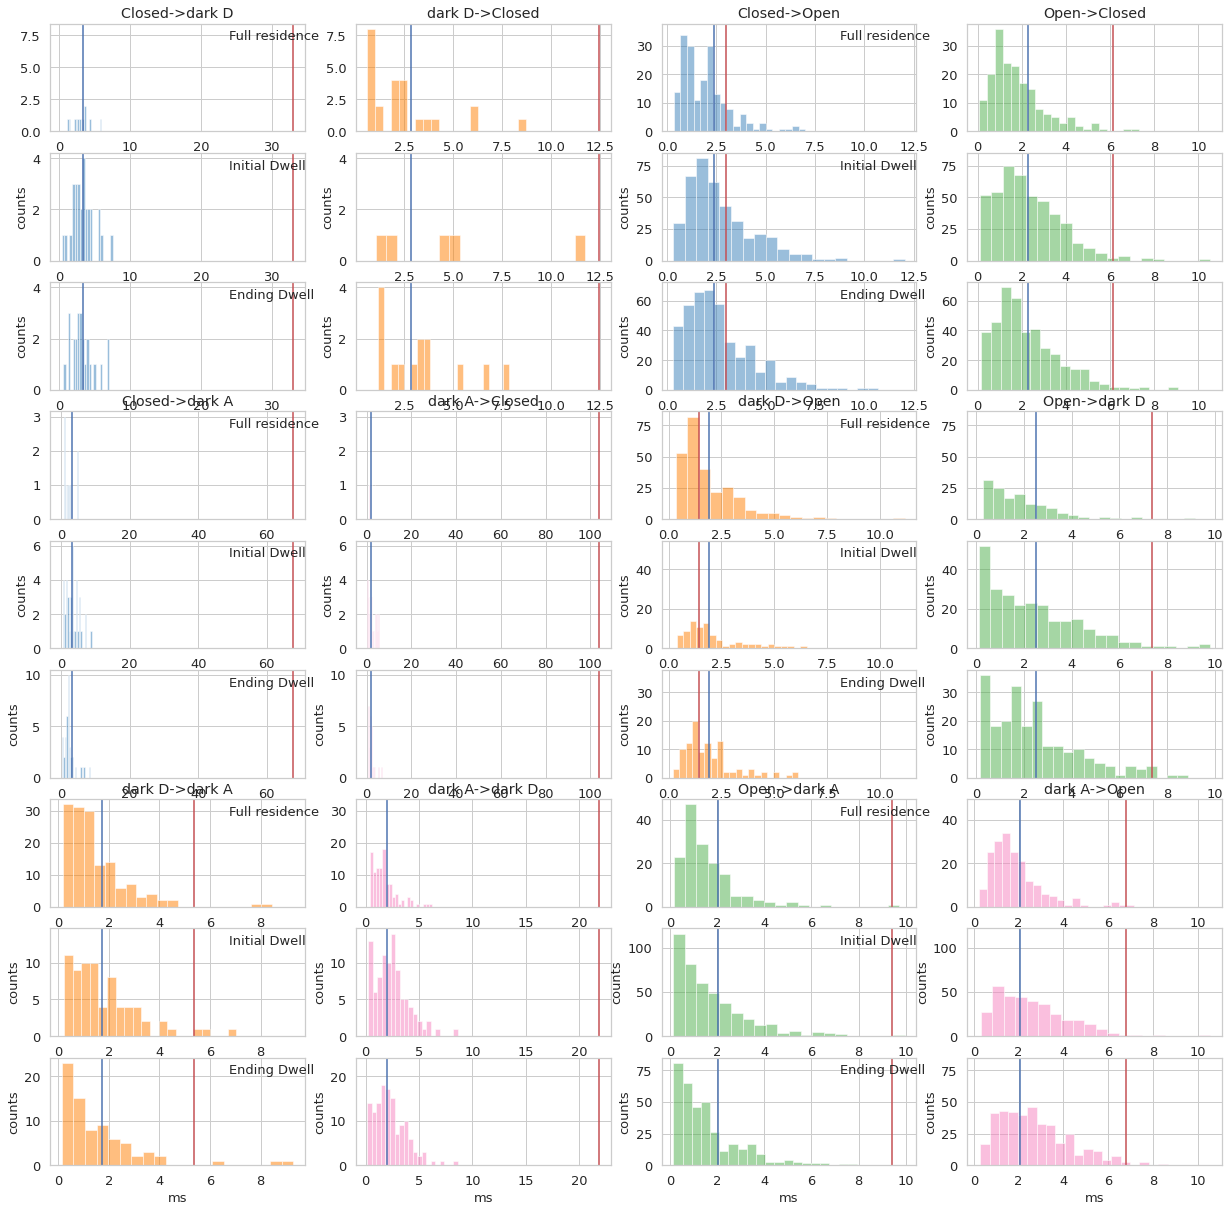

In [56]:
#########################################################################
# Function like inputs, so cell can be coppied and only lines at the top
# need to be changed
mpdata = mpdata_da
state_str = state_names_da
fname = filename.split('.hdf5')[0]
fplot_name = 'DA'
# End of function-like inputs
#########################################################################

# build figure axes
nstate = mpdata.models.ideal + 1
ngraphs = (nstate)*(nstate - 1) // 2
nrows = ngraphs // 2 + (ngraphs % 2)
fig3 = plt.figure(figsize=(21,nrows*7))
gs3 = gridspec.GridSpec(nrows=3*nrows,ncols=4,figure=fig3)
ax3 = [[] for i in range(ngraphs)]
k = 0
stats_frame = mpdata.models[mpdata.models.ideal].stats_frame()
for i in range(nstate):
    for j in range(i+1,nstate):
        macro_row, macro_col = 3*(k//2), 2*(k%2)
        ax3[k].append(fig3.add_subplot(gs3[macro_row,macro_col]))
        bhm.dwell_trans_dur_hist(mpdata.models, from_state=i, to_state=j, ax=ax3[k][0], color=clr[i], 
                                 include_beg=False)
        ax3[k][0].axvline(1000/mpdata.models.trans[i,j],color='r')
        ax3[k][0].axvline(stats_frame[f'to_state_{j}_dwell_dur'][i], color='b')
        ax3[k][0].annotate('Full residence',(0.7,0.85),xycoords='axes fraction')
        ax3[k].append(fig3.add_subplot(gs3[macro_row+1,macro_col],sharex=ax3[k][0]))
        bhm.dwell_dur_hist(mpdata.models, ax=ax3[k][1], states=i, 
                           dwell_pos=lambda model: bhm.begin_dwell(model)*bhm.dwell_trans(model, j),
                           color=clr[i])
        ax3[k][1].axvline(1000/mpdata.models.trans[i,j],color='r')
        ax3[k][1].axvline(stats_frame[f'to_state_{j}_dwell_dur'][i], color='b')
        ax3[k][1].annotate('Initial Dwell',(0.7,0.85),xycoords='axes fraction')
        ax3[k].append(fig3.add_subplot(gs3[macro_row+2,macro_col],sharex=ax3[k][1]))
        bhm.dwell_dur_hist(mpdata.models, ax=ax3[k][2], states=i, 
                           dwell_pos=lambda model: bhm.end_dwell(model)*bhm.dwell_trans_from(model, j),
                           color=clr[i])
        ax3[k][2].annotate('Ending Dwell',(0.7,0.85),xycoords='axes fraction')
        ax3[k][2].axvline(1000/mpdata.models.trans[i,j],color='r')
        ax3[k][2].axvline(stats_frame[f'to_state_{j}_dwell_dur'][i], color='b')
        ax3[k].append(fig3.add_subplot(gs3[macro_row,macro_col+1],sharey=ax3[k][0]))
        bhm.dwell_trans_dur_hist(mpdata.models, from_state=j, to_state=i, ax=ax3[k][3], color=clr[j], 
                                 include_beg=False)
        ax3[k][3].axvline(1000/mpdata.models.trans[j,i],color='r')
        ax3[k][3].axvline(stats_frame[f'to_state_{i}_dwell_dur'][j], color='b')
        ax3[k].append(fig3.add_subplot(gs3[macro_row+1,macro_col+1],sharey=ax3[k][1],sharex=ax3[k][3]))
        bhm.dwell_dur_hist(mpdata.models, ax=ax3[k][4], states=j, 
                           dwell_pos=lambda model: bhm.begin_dwell(model)*bhm.dwell_trans(model, i),
                           color=clr[j])
        ax3[k][4].axvline(1000/mpdata.models.trans[j,i],color='r')
        ax3[k][4].axvline(stats_frame[f'to_state_{i}_dwell_dur'][j], color='b')
        ax3[k].append(fig3.add_subplot(gs3[macro_row+2,macro_col+1],sharey=ax3[k][2],sharex=ax3[k][4]))
        bhm.dwell_dur_hist(mpdata.models, ax=ax3[k][5], states=j, 
                           dwell_pos=lambda model: bhm.end_dwell(model)*bhm.dwell_trans_from(model, i),
                           color=clr[j])
        ax3[k][5].axvline(1000/mpdata.models.trans[j,i],color='r')
        ax3[k][5].axvline(stats_frame[f'to_state_{i}_dwell_dur'][j], color='b')
        ax3[k].append(fig3.add_subplot(gs3[macro_row:macro_row+3,macro_col]))
        ax3[k][6].axis('off')
        ax3[k][6].set_title(state_str[i] + '->' + state_str[j])
        ax3[k].append(fig3.add_subplot(gs3[macro_row:macro_row+3,macro_col+1]))
        ax3[k][7].axis('off')
        ax3[k][7].set_title(state_str[j] + '->' + state_str[i])
        k += 1
# fig3.savefig('figures/'+fname + fplot_name + '_dwellhist.pdf',format='pdf',bbox_inches='tight')

*Write your caption in this cell, below is sample caption.*
*Frames should stay the same, so you can use it as a template*

**Analysis of the $t_{dwell}$ distributions of *Viterbi* based on each state, for the Donor Active selection of the DNA hairpin in 300 mM NaCL.** 
Histograms are grouped in blocks fo 2 columns and 3 rows. 
Each block represents a common set of transitions, each column in the block is a different direction, i.e. one column is from *state A* to *state B*, and the other is *state B* to *state A*. 
The *top row* histograms the $t_{dwell}$ of dwells which begin and end within a burst. 
The *middle row* histograms the $t_{dwell}$ of dwells which begin at the beginning of a burst. 
The *bottom row* histograms teh $t_{dwell}$ of all dwells that end at the end of a burst.

<a id='da_lifetime'></a>
### Assement of Quantum Yield through the Lifetime data

#### Setting [BurstData.irf_thresh](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData.irf_thresh)

Before performing nanotime assesment, it is good to set the [BurstData.irf_thresh](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData.irf_thresh) property.
In the original notebook this was done looking at the decay histograms of individual states.

We now prefer to look at the decays from all bursts, not sorted by states.
Futher, by plotting along the raw TCSPC bin, for setting the [BurstData.irf_thresh](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData.irf_thresh), we can work without one less conversion, removing one possible point of error.

So first let's plot the [raw_nanotime_hist()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.Plotting.raw_nanotime_hist):

([[<matplotlib.lines.Line2D at 0x7efbffbe5c40>],
 <matplotlib.legend.Legend at 0x7efc2007dee0>)

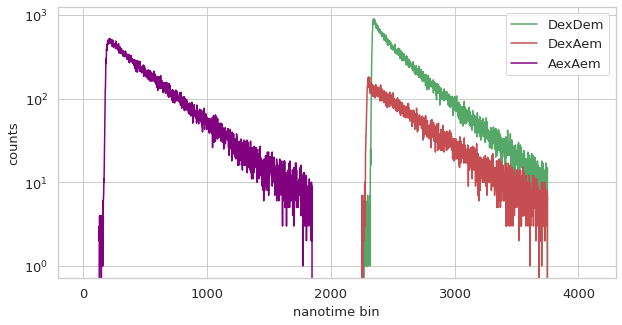

In [57]:
fig, ax = plt.subplots(figsize=(10,5))
bhm.raw_nanotime_hist(mpdata_da, yscale='log', ax=ax)

Now make a guess at where the [BurstData.irf_thresh](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.BurstData.irf_thresh) should be, and check.

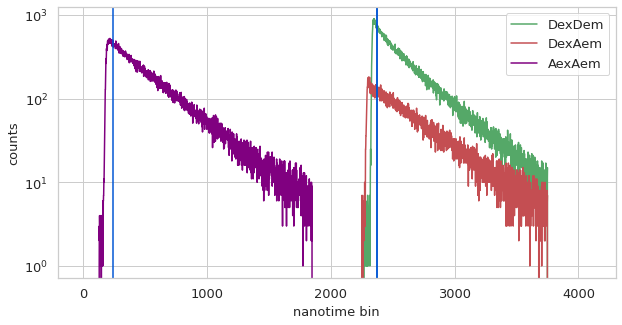

In [58]:
# raw thresholds, set according to your data, don't be affraid to re-run this cell until it looks right
raw_thresh = [2374, 2374, 245]

fig, ax = plt.subplots(figsize=(10,5))
bhm.raw_nanotime_hist(mpdata_da, yscale='log', ax=ax)

for th in raw_thresh:
    ax.axvline(th)

If the above cell looks right, set the thresholds

> **Note**
>
> Since all our BurstData came from the same raw data, we can use the same thresholds, 
> even if they are different burst selections.
> Only we will have to remove the last stream for the spH<sup>2</sup>MM models

In [59]:
mpdata_da.irf_thresh = raw_thresh
mpdata_fret.irf_thresh = raw_thresh
spdata_da.irf_thresh = raw_thresh[:-1]
spdata_fret.irf_thresh = raw_thresh[:-1]

Now lets plot the decays for each state and see how well each looks with the IRF thresholds:

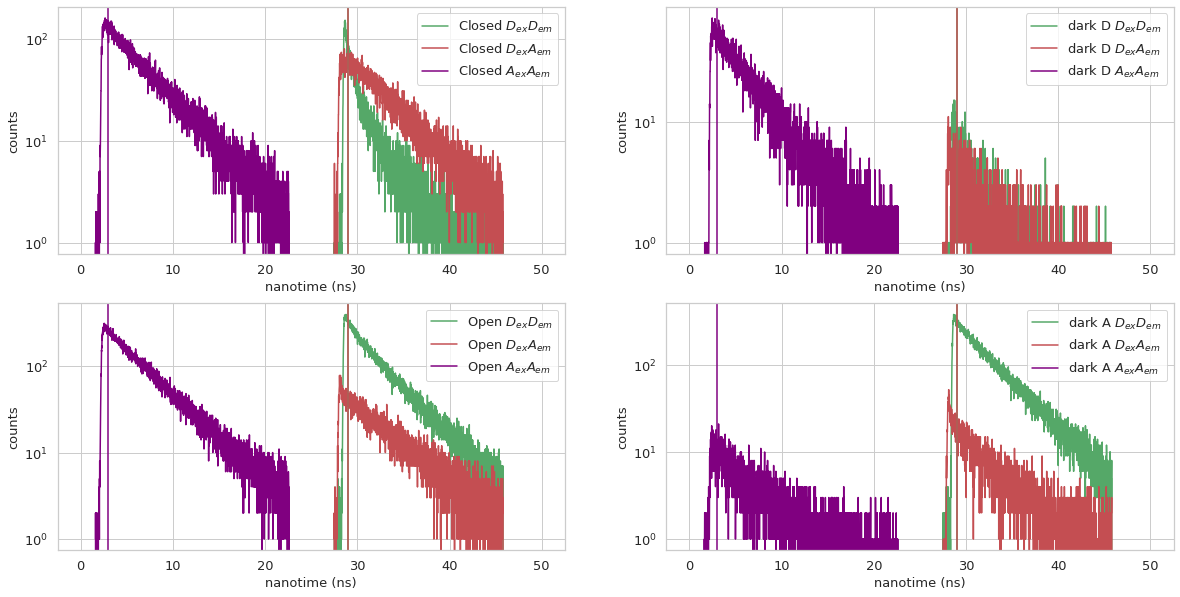

In [60]:
mpdata = mpdata_da
state_names = state_names_da
ns_thresholds = [29,29,3]

# build figure axes
fig_nt = plt.figure(figsize=(20,5*((mpdata.models.ideal + 1) // 2) ))
gs_nt = gridspec.GridSpec(ncols=2,nrows=((mpdata.models.ideal + 1) // 2))
ax_nt = [fig_nt.add_subplot(gs_nt[i//2, i%2]) for i in range(mpdata.models.ideal+1)]

raw_thresholds = [int(th /mpdata.data.nanotimes_params[0]['tcspc_unit'] / 1e9) for th in ns_thresholds]
mpdata.irf_thresh = raw_thresholds

for i, state in enumerate(state_names):
    bhm.state_nanotime_hist(mpdata.models, ax=ax_nt[i], states=i, 
                            streams=mpdata.ph_streams, stream_kwargs=st_kw(state, mpdata), 
                            raw_bin=False)
    ax_nt[i].legend()
    bhm.axline_irf_thresh(mpdata, ax=ax_nt[i], 
                          stream_kwargs=[{'color':stream_color[sel]} for sel in mpdata.ph_streams], 
                          raw_bin=False)
    

Now that the IRF is excluded, the mean arrival time can be calculated, which allows us to calculate the lifetime

array([[2.76325964, 4.40415066, 4.33452875],
       [3.67506514, 4.38479307, 4.17718796],
       [3.60081483, 4.56385298, 4.10769111],
       [3.7774879 , 4.27441388, 4.74565177]])

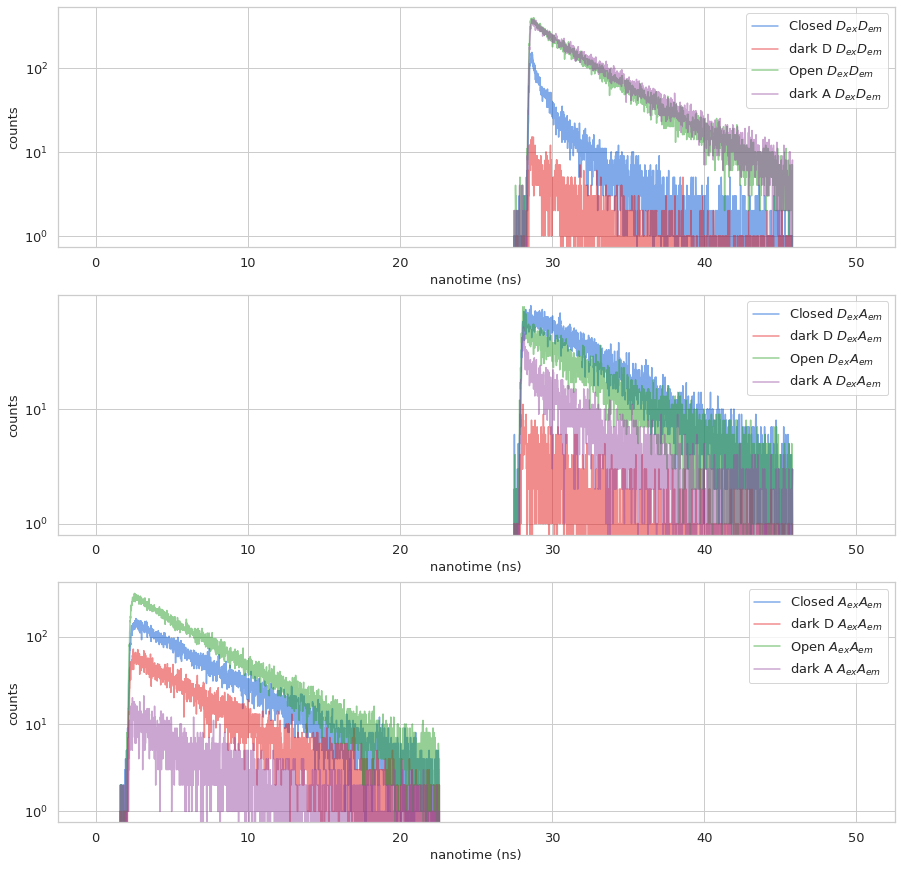

In [61]:
mpdata = mpdata_da
state_names = state_names_da
state_names = state_names_da

# build figure axes
fig_nt = plt.figure(figsize=(15,5*len(mpdata.ph_streams)))
gs_nt = gridspec.GridSpec(ncols=1,nrows=len(mpdata.ph_streams))
ax_nt = [fig_nt.add_subplot(gs_nt[j,0]) for j in range(len(mpdata.ph_streams))]

for i, stream in enumerate(mpdata.ph_streams):
    bhm.state_nanotime_hist(mpdata.models, streams=stream, ax=ax_nt[i], 
                            state_kwargs=[{'label':f'{state} {stream_label[stream]}'} for state in state_names],
                           alpha=0.5)
    ax_nt[i].legend()

# fig_nt.savefig('figures/'+fname+'DA_decays.pdf',format='pdf',bbox_inches='tight')
mpdata.models.state_nano_mean

*Write your caption in this cell, below is sample caption.*
*Frames should stay the same, so you can use it as a template*

**Comparison of fluorescent lifetime decays of states derived from *Viterbi* analysis, based on Donor Active burst selection.** 
*Top panel:* Donor decays, ($D_{ex}D_{em}$). 
*Middle panel:* Acceptor FRET decays ($D_{ex}A_{em}$), 
*Bottom panel:* ($A_{ex}A_{em}$).

<a id='fret_result'></a>
## Examining FRET burst selection results

As with the Donor active selection, we need to know the order of states so we can give each an appropriate name for our FRET selection

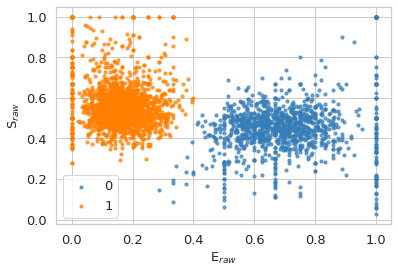

In [62]:
mpdata = mpdata_fret
bhm.dwell_ES_scatter(mpdata.models, state_kwargs=[{'label':f'{i}', 'c':clr[i]} 
                                                  for i in range(mpdata.models.ideal+1)])
plt.legend()

Again, let's give each state a name:

In [63]:
state_names_fret = ['Closed','Open']

<a id='fret_mainplot'></a>
## Plot information relevant to 2D E-S plots for FRET burst selection

 - Computing histogram.


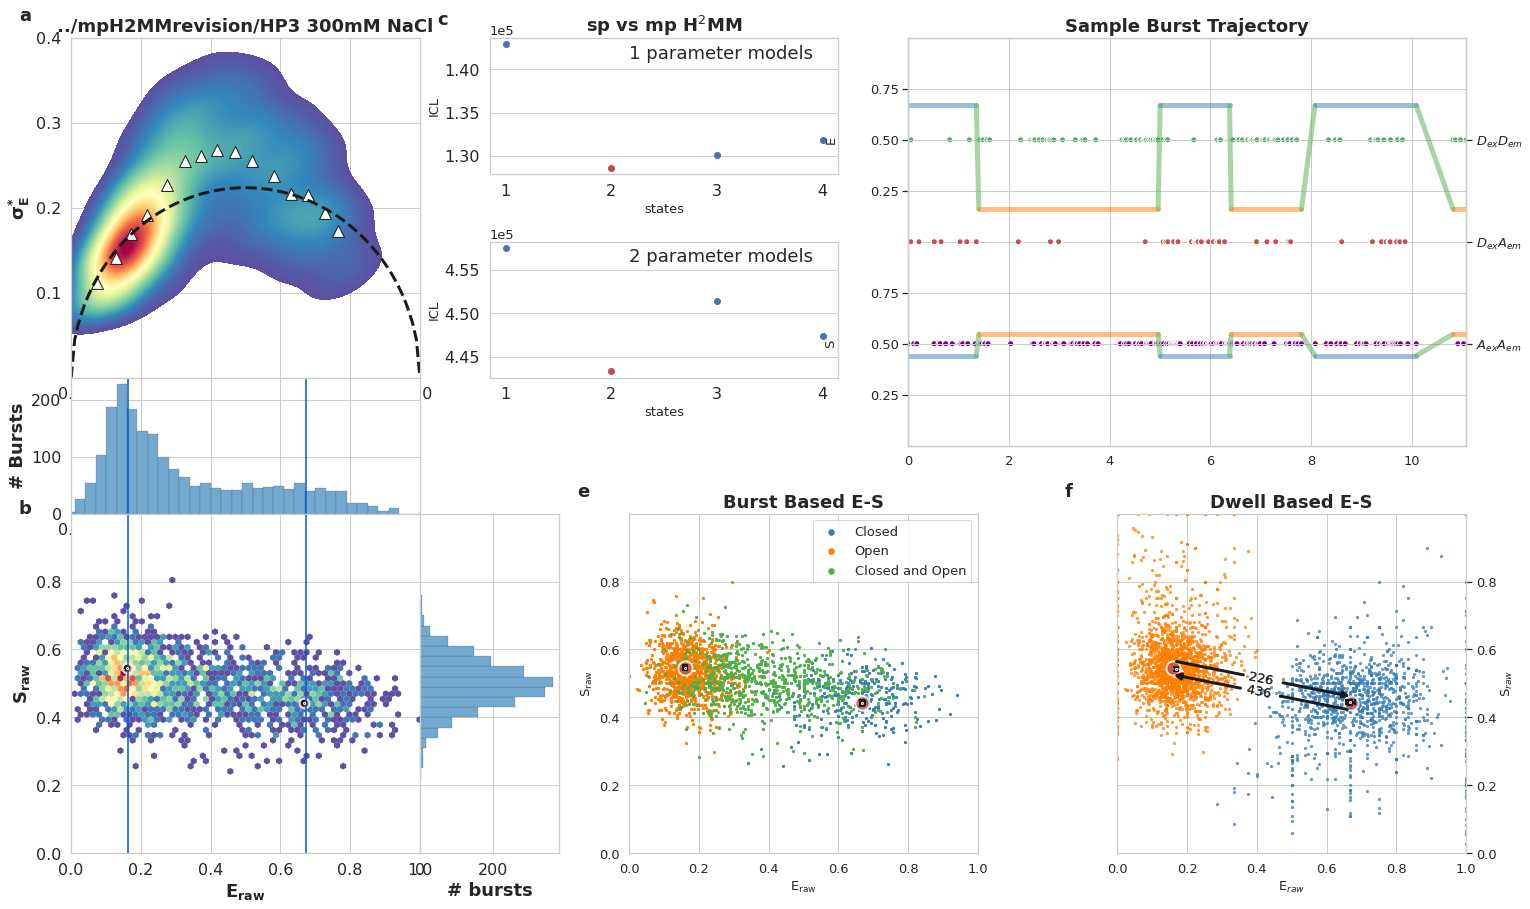

In [64]:
#########################################################################
# Function like inputs, so cell can be coppied and only lines at the top
# need to be changed
data = d_fret
spdata = spdata_fret
mpdata = mpdata_fret

# Non data settings
state_names = state_names_fret
fname = filename.split('.hdf5')[0]
plot_sel = 'DCBS'
fplot_sel = 'DCBS'
burst_marker_size = 5
plot_t = plot_title
# End of function-like inputs
#########################################################################
        
# set up the figures subplots
fig1 = plt.figure(figsize=(25,15))
gs1 = gridspec.GridSpec(nrows=12,ncols=20,figure=fig1)
plt.subplots_adjust(hspace=0, wspace=0)
ax1 = []
ax1.append(fig1.add_subplot(gs1[0:5,0:5])) # BVA plot ax1[0]
ax1.append(fig1.add_subplot(gs1[5:7,0:5],sharex=ax1[0])) # 1D FRET histogram ax1[1]
ax1.append(fig1.add_subplot(gs1[7:12,0:5],sharex=ax1[0])) # ES hexbin plot ax1[2]
ax1.append(fig1.add_subplot(gs1[7:12:,5:7],sharey=ax1[2])) # S histogram ax1[3]
ax1.append(fig1.add_subplot(gs1[0:2,6:11])) # 1pH2MM BIC' ax1[4]
ax1.append(fig1.add_subplot(gs1[3:5,6:11])) # 2pH2MM BIC' ax1[5]
ax1.append(fig1.add_subplot(gs1[0:6,12:20])) # E photon path ax1[6]
ax1.append(fig1.add_subplot(gs1[7:12,8:13], sharey=ax1[2], sharex=ax1[2])) # Burst based E-S viterbi calssification ax1[7]
ax1.append(fig1.add_subplot(gs1[7:12,15:20],sharey=ax1[7],sharex=ax1[7])) # Dwell based E-S viterbi classification ax1[8]

# plotting the BVA plot
E_fret, std_fret = BVA(data, n)
E_fret_bin, std_fret_bin = bin_bva(E_fret, std_fret, R, B_Thr)
E_fret, std_fret = np.concatenate(E_fret), np.concatenate(std_fret)
im = sns.kdeplot(x=E_fret, y=std_fret,shade=True, cmap='Spectral_r', n_levels=plot_levels, 
                 thresh=0.05, gridsize=100, ax=ax1[0])
ax1[0].scatter(E_fret_bin, std_fret_bin, marker='^',s=140,color='white',edgecolors='k',alpha=1)
ax1[0].set_ylim([0,0.4])
x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
ax1[0].plot(x_T,y_T, lw=3, color='k', ls='--')
ax1[0].set_ylabel('$\mathbf{\sigma_{E}^{*}}$',fontsize=18)

# plotting the E and S histograms that surround the ES hexbin plot
frb.dplot(data, frb.hist_fret, ax=ax1[1], pdf=False, weights=None, verbose=True)
frb.dplot(data, frb.hist_burst_data, data_name='S', ax=ax1[3], vertical=True)
frb.dplot(data, frb.hexbin_alex, ax=ax1[2])
bhm.scatter_ES(mpdata.models,  color='r',marker='o', s=100, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='loglik')
bhm.axline_E(spdata.models, ax=ax1[1])
bhm.axline_E(spdata.models, ax=ax1[2])

# set limits and labels on first column 
ax1[0].set_yticks(np.arange(0.1,0.5,0.1))
ax1[1].set_ylabel('# Bursts',fontsize=18,fontweight='bold')
ax1[2].set_xlabel('$\mathbf{E_{raw}}$',fontsize=18,)
ax1[2].set_ylabel('$\mathbf{S_{raw}}$',fontsize=18)
ax1[2].set_yticks([0,0.2,0.4,0.6,0.8])
ax1[0].set_xlim([0,1])
ax1[0].set_title(plot_title,fontsize=18,fontweight='bold')
ax1[0].tick_params(labelsize=16)
ax1[1].tick_params(labelsize=16)
ax1[2].tick_params(labelsize=16)
ax1[3].tick_params(labelsize=16)
ax1[2].set_ylim([0,1])
ax1[0].text(-0.15,1.05,'a',fontsize=18,fontweight='bold',transform=ax1[0].transAxes)
ax1[1].set_title(' ')
ax1[2].set_title(' ')
ax1[2].text(-0.15,1.0,'b',fontsize=18,fontweight='bold',transform=ax1[2].transAxes)
ax1[3].set_title(' ')
ax1[3].set_ylabel(' ')
ax1[3].set_xlabel('# bursts',fontsize=18,fontweight='bold')
plt.setp(ax1[3].get_yticklabels(), visible=False)

# ICL plots
bhm.ICL_plot(spdata.models, highlight_ideal=True, ax=ax1[4])
bhm.ICL_plot(mpdata.models, highlight_ideal=True, ax=ax1[5])
ax1[4].grid(axis='x')
ax1[4].set_xticks(np.arange(1, max([spdata.models.max_opt, mpdata.models.max_opt])+1))
ax1[4].tick_params(labelsize=16)
ax1[4].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax1[4].annotate('1 parameter models',(0.4,0.85),xycoords='axes fraction',fontsize=18)
ax1[4].set_title("sp vs mp H$^2$MM",fontsize=18,fontweight='bold')
ax1[4].text(-0.15,1.1,'c',fontsize=18,fontweight='bold',transform=ax1[4].transAxes)
# ax1[4].set_ylabel("ICL",fontsize=18,fontweight='bold')
ax1[5].grid(axis='x')
ax1[5].set_xticks(np.arange(1, max([spdata.models.max_opt, mpdata.models.max_opt])+1))
ax1[5].tick_params(labelsize=16)
ax1[5].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax1[5].annotate('2 parameter models',(0.4,0.85),xycoords='axes fraction',fontsize=18)
# ax1[5].set_ylabel("ICL",fontsize=18,fontweight='bold')
# ax1[5].set_xlabel("Number of States",fontsize=18,fontweight='bold')

# # plot photon path
bhm.plot_burstjoin(mpdata.models[mpdata.models.ideal], 'transitions', ax=ax1[6], 
                   state_color=clr[:4], path_kwargs={'linewidth':5, 'alpha':0.5})
ax1[6].set_title('Sample Burst Trajectory',fontsize=18,fontweight='bold')


# set up names for burst and dwell-based plots
burst_kwargs, order = burst_color_comb(state_names, clr)

state_kwargs = [burst_kwargs[(2**i)-1] for i in range(len(state_names))]

collections = bhm.burst_ES_scatter(mpdata, ax=ax1[7], s=burst_marker_size, type_kwargs=burst_kwargs)
bhm.scatter_ES(mpdata, ax=ax1[7], color='r',marker='o', s=200, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='bootstrap_std')
# sort labels by number of states
labels = [collections[i].get_label() for i in order]
collections_order = [collections[i] for i in order]
# isolate unique labels
unique = [i for i, label in enumerate(labels) if label not in labels[:i]]
# trim labels down
labels = [labels[i] for i in unique]
handles = [collections_order[i] for i in unique]

legend = ax1[7].legend(handles, labels, bbox_to_anchor=(1.0,1.0))
for leg in legend.legendHandles:
    leg.set_sizes([30.0])

ax1[7].set_title('Burst Based E-S',fontsize=18,fontweight='bold')
ax1[7].text(-0.15,1.05,'e',fontsize=18, fontweight='bold',transform=ax1[7].transAxes)
# ax1[7].set_xlabel('$\mathbf{E_{raw}}$',fontsize=18)
# ax1[7].set_ylabel('$\mathbf{S_{raw}}$',fontsize=18)
# ax1[7].legend(bbox_to_anchor=(1.0, 1.0))

bhm.dwell_ES_scatter(mpdata.models, ax=ax1[8], s=burst_marker_size, state_kwargs=state_kwargs)
bhm.scatter_ES(mpdata.models, ax=ax1[8], color='r',marker='o', s=200, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='viterbi_std')
bhm.trans_arrow_ES(mpdata.models, ax=ax1[8], arrowprops=dict(linewidth=3))
ax1[8].set_title('Dwell Based E-S',fontsize=18,fontweight='bold')
ax1[8].text(-0.15,1.05,'f',fontsize=18, fontweight='bold',transform=ax1[8].transAxes)
# ax1[8].set_xlabel('$\mathbf{E_{raw}}$',fontsize=18)
# ax1[8].set_ylabel('$\mathbf{S_{raw}}$',fontsize=18)
ax1[8].yaxis.set_ticks_position("right")
ax1[8].yaxis.set_label_position("right")
# fig1.savefig('figures/'+fname+fplot_sel+'_summary_type0.pdf',format='pdf',bbox_inches='tight')

*Write your caption in this cell, below is sample caption.*
*Frames should stay the same, so you can use it as a template*

**mpH<sup>2</sup>MM results for DNA hairpin at 300 mM NaCl, DCBS burst selection.** 
a) Burst variance analysis (BVA), the standard deviation of $E_{raw}$ values of bursts is displayed versus their $E_{raw}$ values. 
Bursts with standard deviations higher than expected solely from shot noise (semicircle), are ones that include dynamic heterogeneity, such as within-burst FRET dynamics. 
Triangles indicate the average of standard deviation values per $E_{raw}$ bin. 
b) 2D histogram of $E_{raw}$ and $S_{raw}$ (E-S plots, colloquially) of bursts. 
The $E_{raw}$ and $S_{raw}$ values of sub-populations derived from mpH<sup>2</sup>MM are marked by red circles, and the standard deviation (SD) of these values, derived from the *Viterbi* dwell time analysis, are marked by black crosses. 
Vertical blue bars indicated $E_{raw}$ derived from spH<sup>2</sup>MM. 
c) Comparison of values of the integrated complete likelihood ($ICL$) of spH<sup>2</sup>MM (top panel) and mpH<sup>2</sup>MM (bottom panel) of optimized models with different numbers of states. 
The ideal state-model is marked in red. 
d) Comparison of values of the modified Bayesian Information Criterion ($BIC'$) of optimized models with different numbers of states, using spH<sup>2</sup>MM (top pannel) and mpH<sup>2</sup>MM (bottom pannel), the model with the fewest number of states with a BIC' less than 0.005 is marked in red. 
e) A sample burst trajectory, with photons represented as colored vertical bars, with donor excitation photons colored green or red for donor and acceptor, respectively, and acceptor excitation photons colored purple. 
$E_{raw}$ (top panel) and $S_{raw}$ (bottom panel) of sub-populations determined from dwells using the *Viterbi* algorithm, are overlayed on the photon bars. 
e,f) E-S scatter plots of data processed by the *Viterbi* algorithm. 
mpH<sup>2</sup>MM sub-populations and *Viterbi* -derived standard deviations (SD) are overlayed as red circles and black crosses, respectively.

Text(0.5, 1.0, 'Sample Burst Trajectories')

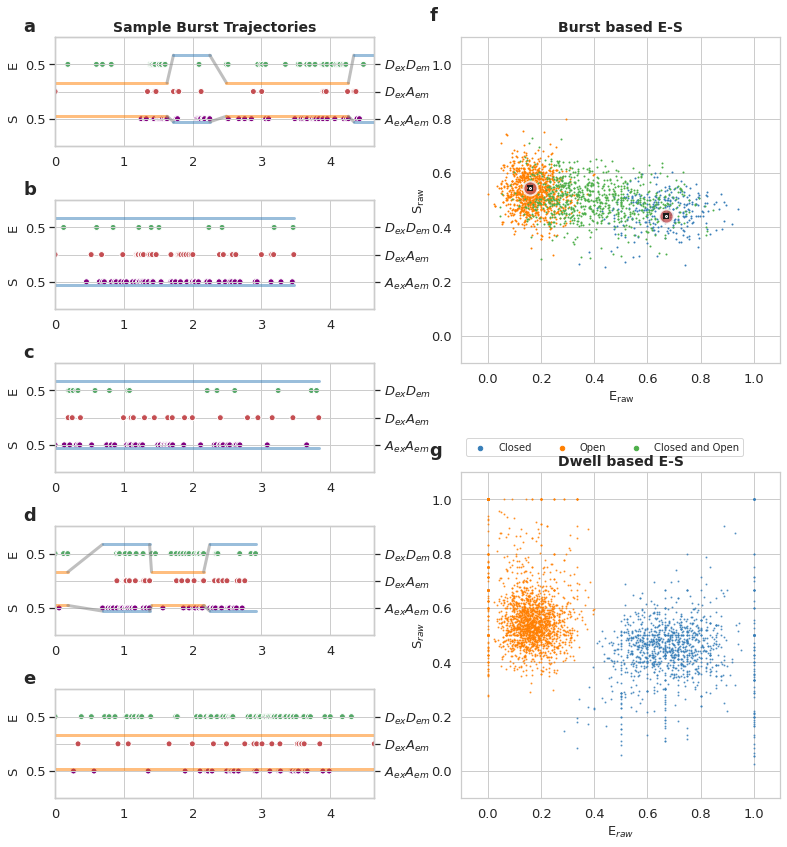

In [65]:
#########################################################################
# Function like inputs, so cell can be coppied and only lines at the top
# need to be changed
mpdata = mpdata_fret
state_names = state_names_fret
bursts = [i*10 for i in range(5)]
fname = filename.split('.hdf5')[0]
fplot_sel = 'DA'
# End of function-like inputs
#########################################################################

assert len(bursts) == 5

# build axes
fig = plt.figure(figsize=(13,14))
gs = gridspec.GridSpec(nrows=14,ncols=13,figure=fig)
plt.subplots_adjust(hspace=0.0, wspace=1)
axt = list()
for i in range(5):
    ax = fig.add_subplot(gs[(3*i):(3*i+2),0:6], sharex=axt[0] if i != 0 else None)
    ax.text(-0.1,1.05,chr(ord('a')+i),fontsize=18,fontweight='bold',transform=ax.transAxes)
    axt.append(ax)
axs = [fig.add_subplot(gs[0:6,7:13]),]
axs.append(fig.add_subplot(gs[8:14,7:13], sharex=axs[0], sharey=axs[0]))

# build arguments for burst and dwell plots
burst_kwargs, order = burst_color_comb(state_names, clr)
state_kwargs = [burst_kwargs[(2**i)-1] for i in range(len(state_names))]
path_state_color = [sk['c'] for sk in state_kwargs]

collections = bhm.burst_ES_scatter(mpdata, ax=axs[0], s=1, type_kwargs=burst_kwargs)
bhm.scatter_ES(mpdata, ax=axs[0], color='r',marker='o', s=200, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='bootstrap_std')
# sort labels by number of states
labels = [collections[i].get_label() for i in order]
collections_order = [collections[i] for i in order]
# isolate unique labels
unique = [i for i, label in enumerate(labels) if label not in labels[:i]]
# trim labels down
labels = [labels[i] for i in unique]
handles = [collections_order[i] for i in unique]

legend = axs[0].legend(handles, labels, title="",loc='lower left',bbox_to_anchor=(0.0,-0.3),fontsize=10,ncol=3)
for leg in legend.legendHandles:
    leg.set_sizes([20.0])

bhm.dwell_ES_scatter(mpdata, ax=axs[1], s=1, state_kwargs=state_kwargs)


axs[0].text(-0.1,1.05,'f',fontsize=18,fontweight='bold',transform=axs[0].transAxes)
axs[0].set_title("Burst based E-S",fontsize=14,fontweight='bold')

axs[1].set_xlim([-0.1,1.1])
axs[1].set_ylim([-0.1,1.1])
axs[0].text(-0.1,1.05,'g',fontsize=18,fontweight='bold',transform=axs[1].transAxes)
axs[1].set_title("Dwell based E-S",fontsize=14,fontweight='bold')


for i, b in enumerate(bursts):
    bhm.plot_burstjoin(mpdata.models, b, ax=axt[i], state_color=path_state_color, 
                       path_kwargs={'linewidth':3, 'alpha':0.5})
    
axt[0].set_title('Sample Burst Trajectories',fontsize=14,fontweight='bold')
# fig.savefig('figures/'+fname+fplot_sel+'_viterbi.pdf',format='pdf',bbox_inches='tight')

*Write your caption in this cell, below is sample caption.*
*Frames should stay the same, so you can use it as a template*

**mpH<sup>2</sup>MM *Viterbi* analysis of DNA haripin at 300mM NaCl, DCBS burst selection.** 
a-e) Selected photon traces with the *Viterbi* derived most likely state paths overlayed. 
Photons are represented as verticle bars colored according to the photon stream, (green for D<sub>ex</sub>D<sub>em</sub> photons, red for D<sub>ex</sub>A<sub>em</sub> photons, and purple for A<sub>ex</sub>A<sub>em</sub> photons). 
Horizontal line represents the $E_{raw}$ (upper pannel) and $S_{raw}$ of the state predicted by the *Viterbi* algorithm. 
e,f) E-S scatter plot of bursts (f) or dwells within bursts (g), color coded by which states are present in the bursts (f) or according to the state of the dwell (g), according to Viterbi algorithm. 
Colors are consistent throughout, with states in a-e colored as in g, and the borders of the burst traces colored as in f.

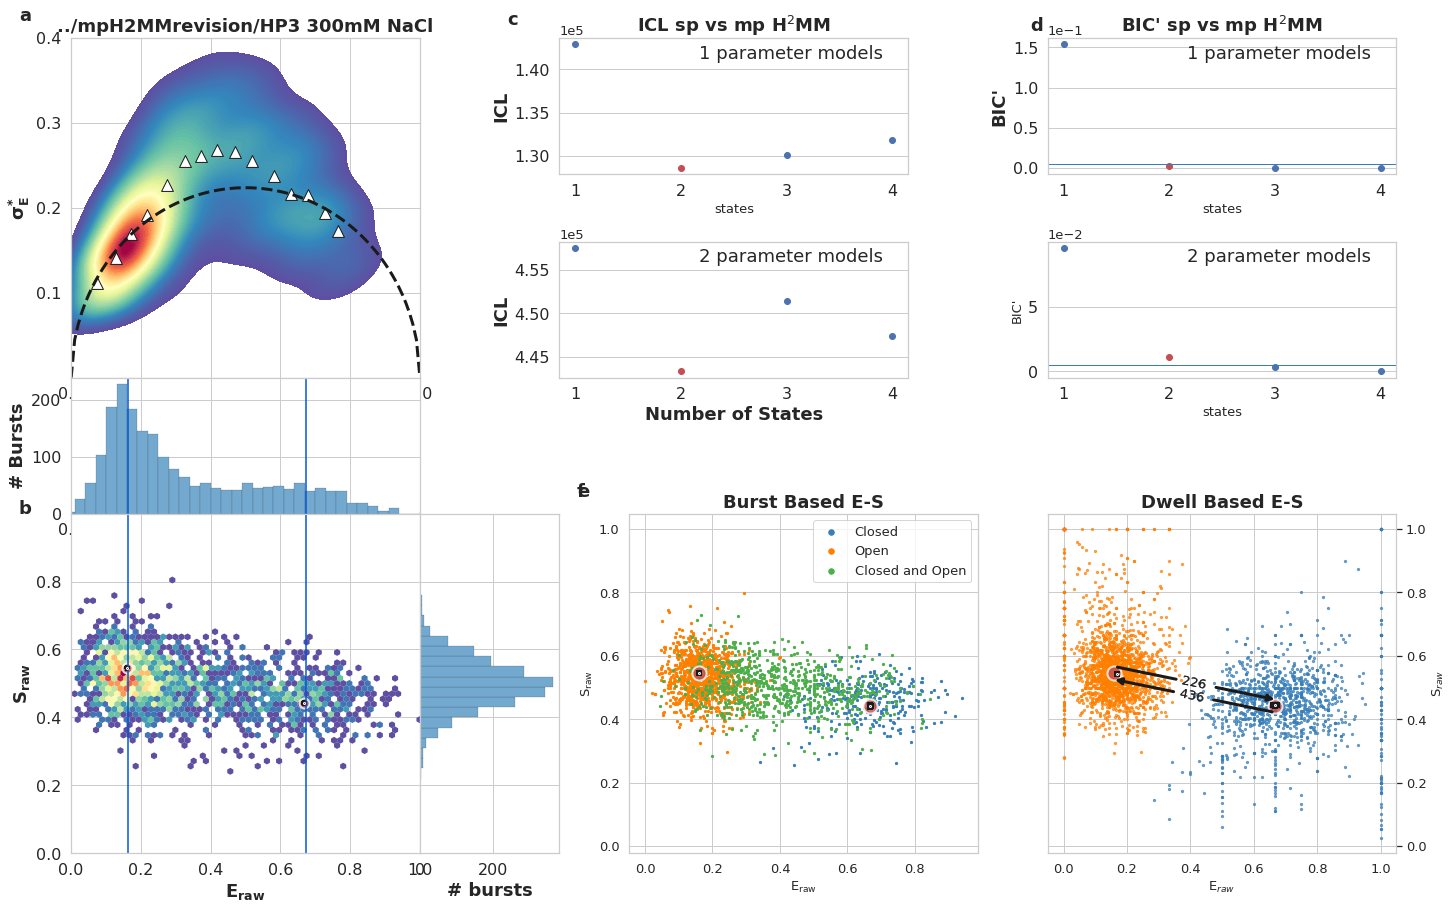

In [66]:
#########################################################################
# Function like inputs, so cell can be coppied and only lines at the top
# need to be changed
data = d_fret
spdata = spdata_fret
mpdata = mpdata_fret
# Non data settings
state_names = state_names_fret
fname = filename.split('.hdf5')[0]
plot_sel = 'DCBS'
fplot_sel = 'DCBS'
burst_marker_size = 5
barwidth = 0.02
plot_t = plot_title
# End of function-like inputs
#########################################################################


# set up the figures subplots
fig1 = plt.figure(figsize=(25,15))
gs1 = gridspec.GridSpec(nrows=12,ncols=20,figure=fig1)
plt.subplots_adjust(hspace=0, wspace=0)
ax1 = []
ax1.append(fig1.add_subplot(gs1[0:5,0:5])) # BVA plot ax1[0]
ax1.append(fig1.add_subplot(gs1[5:7,0:5],sharex=ax1[0])) # 1D FRET histogram ax1[1]
ax1.append(fig1.add_subplot(gs1[7:12,0:5],sharex=ax1[0])) # ES hexbin plot ax1[2]
ax1.append(fig1.add_subplot(gs1[7:12:,5:7],sharey=ax1[2])) # S histogram ax1[3]
ax1.append(fig1.add_subplot(gs1[0:2,7:12])) # 1pH2MM ICL ax1[4]
ax1.append(fig1.add_subplot(gs1[3:5,7:12],sharex=ax1[4])) # 2pH2MM ICL ax1[5]
ax1.append(fig1.add_subplot(gs1[0:2,14:19])) # 1pH2MM BIC' ax1[6]
ax1.append(fig1.add_subplot(gs1[3:5,14:19],sharex=ax1[6])) # 2pH2MM BIC' ax1[7]
ax1.append(fig1.add_subplot(gs1[7:12,8:13])) # Burst based E-S viterbi calssification ax1[8]
ax1.append(fig1.add_subplot(gs1[7:12,14:19],sharey=ax1[8])) # Dwell based E-S viterbi classification ax1[9]

# plotting the BVA plot
E_fret, std_fret = BVA(data, n)
E_fret_bin, std_fret_bin = bin_bva(E_fret, std_fret, R, B_Thr)
E_fret, std_fret = np.concatenate(E_fret), np.concatenate(std_fret)
im = sns.kdeplot(x=E_fret, y=std_fret,shade=True, cmap='Spectral_r', n_levels=plot_levels, 
                 thresh=0.05, gridsize=100, ax=ax1[0])
ax1[0].scatter(E_fret_bin, std_fret_bin, marker='^',s=140,color='white',edgecolors='k',alpha=1)
ax1[0].set_ylim([0,0.4])
x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
ax1[0].plot(x_T,y_T, lw=3, color='k', ls='--')
ax1[0].set_ylabel('$\mathbf{\sigma_{E}^{*}}$',fontsize=18)

# plotting the E and S histograms that surround the ES hexbin plot
frb.dplot(data, frb.hist_fret, ax=ax1[1], pdf=False, weights=None, verbose=True)
frb.dplot(data, frb.hist_burst_data, data_name='S', ax=ax1[3], vertical=True)
frb.dplot(data, frb.hexbin_alex, ax=ax1[2])
bhm.scatter_ES(mpdata.models,  color='r',marker='o', s=100, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='loglik')
bhm.axline_E(spdata.models, ax=ax1[1])
bhm.axline_E(spdata.models, ax=ax1[2])

# set limits and labels on first column 
ax1[0].set_yticks(np.arange(0.1,0.5,0.1))
ax1[1].set_ylabel('# Bursts',fontsize=18,fontweight='bold')
ax1[2].set_xlabel('$\mathbf{E_{raw}}$',fontsize=18,)
ax1[2].set_ylabel('$\mathbf{S_{raw}}$',fontsize=18)
ax1[2].set_yticks([0,0.2,0.4,0.6,0.8])
ax1[0].set_xlim([0,1])
ax1[0].set_title(plot_title,fontsize=18,fontweight='bold')
ax1[0].tick_params(labelsize=16)
ax1[1].tick_params(labelsize=16)
ax1[2].tick_params(labelsize=16)
ax1[3].tick_params(labelsize=16)
ax1[2].set_ylim([0,1])
ax1[0].text(-0.15,1.05,'a',fontsize=18,fontweight='bold',transform=ax1[0].transAxes)
ax1[1].set_title(' ')
ax1[2].set_title(' ')
ax1[2].text(-0.15,1.0,'b',fontsize=18,fontweight='bold',transform=ax1[2].transAxes)
ax1[3].set_title(' ')
ax1[3].set_ylabel(' ')
ax1[3].set_xlabel('# bursts',fontsize=18,fontweight='bold')
plt.setp(ax1[3].get_yticklabels(), visible=False)

# ICL plots
bhm.ICL_plot(spdata.models, highlight_ideal=True, ax=ax1[4])
bhm.ICL_plot(mpdata.models, highlight_ideal=True, ax=ax1[5])
ax1[4].grid(axis='x')
ax1[4].set_xticks(np.arange(1, max([spdata.models.max_opt, mpdata.models.max_opt])+1))
ax1[4].tick_params(labelsize=16)
ax1[4].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax1[4].annotate('1 parameter models',(0.4,0.85),xycoords='axes fraction',fontsize=18)
ax1[4].set_title("ICL sp vs mp H$^2$MM",fontsize=18,fontweight='bold')
ax1[4].text(-0.15,1.1,'c',fontsize=18,fontweight='bold',transform=ax1[4].transAxes)
ax1[4].set_ylabel("ICL",fontsize=18,fontweight='bold')
ax1[5].grid(axis='x')
ax1[5].set_xticks(np.arange(1, max([spdata.models.max_opt, mpdata.models.max_opt])+1))
ax1[5].tick_params(labelsize=16)
ax1[5].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax1[5].annotate('2 parameter models',(0.4,0.85),xycoords='axes fraction',fontsize=18)
ax1[5].set_ylabel("ICL",fontsize=18,fontweight='bold')
ax1[5].set_xlabel("Number of States",fontsize=18,fontweight='bold')

# plot BIC'
bhm.BICp_plot(spdata.models, ax=ax1[6], highlight_ideal=True)
bhm.BICp_plot(mpdata.models, ax=ax1[7], highlight_ideal=True)
ax1[6].axhline(bicp_min,c=clr[0],ls='-',lw=1)
ax1[7].axhline(bicp_min,c=clr[0],ls='-',lw=1)
ax1[6].grid(axis='x')
ax1[6].set_xticks(np.arange(1, max([spdata.models.max_opt, mpdata.models.max_opt])+1))
ax1[6].tick_params(labelsize=16)
ax1[6].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax1[6].annotate('1 parameter models',(0.4,0.85),xycoords='axes fraction',fontsize=18)
ax1[6].set_title("BIC' sp vs mp H$^2$MM",fontsize=18,fontweight='bold')
ax1[6].text(-0.05,1.05,'d',fontsize=18,fontweight='bold',transform=ax1[6].transAxes)
ax1[6].set_ylabel("BIC'",fontsize=18,fontweight='bold')
ax1[7].grid(axis='x')
ax1[7].set_xticks(np.arange(1, max([spdata.models.max_opt, mpdata.models.max_opt])+1))
ax1[7].tick_params(labelsize=16)
ax1[7].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax1[7].annotate('2 parameter models',(0.4,0.85),xycoords='axes fraction',fontsize=18)
# ax1[7].set_ylabel("ICL",fontsize=18,fontweight='bold')
# ax1[7].set_xlabel("Number of States",fontsize=18,fontweight='bold')



# set up names for burst and dwell-based plots
burst_kwargs, order = burst_color_comb(state_names, clr)

state_kwargs = [burst_kwargs[(2**i)-1] for i in range(len(state_names))]

collections = bhm.burst_ES_scatter(mpdata, ax=ax1[8], s=burst_marker_size, type_kwargs=burst_kwargs)
bhm.scatter_ES(mpdata, ax=ax1[8], color='r',marker='o', s=200, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='bootstrap_std')
# sort labels by number of states
labels = [collections[i].get_label() for i in order]
collections_order = [collections[i] for i in order]
# isolate unique labels
unique = [i for i, label in enumerate(labels) if label not in labels[:i]]
# trim labels down
labels = [labels[i] for i in unique]
handles = [collections_order[i] for i in unique]

legend = ax1[8].legend(handles, labels, bbox_to_anchor=(1.0,1.0))
for leg in legend.legendHandles:
    leg.set_sizes([30.0])

ax1[8].set_title('Burst Based E-S',fontsize=18,fontweight='bold')
ax1[8].text(-0.15,1.05,'e',fontsize=18, fontweight='bold',transform=ax1[8].transAxes)
# ax1[8].set_xlabel('$\mathbf{E_{raw}}$',fontsize=18)
# ax1[8].set_ylabel('$\mathbf{S_{raw}}$',fontsize=18)
# ax1[8].legend(bbox_to_anchor=(1.0, 1.0))

bhm.dwell_ES_scatter(mpdata.models, ax=ax1[9], s=burst_marker_size, state_kwargs=state_kwargs)
bhm.scatter_ES(mpdata.models, ax=ax1[9], color='r',marker='o', s=200, edgecolors='white', 
               linewidths=2, alpha=0.8, errorbar='viterbi_std')
bhm.trans_arrow_ES(mpdata.models, ax=ax1[9], arrowprops=dict(linewidth=3))
ax1[9].set_title('Dwell Based E-S',fontsize=18,fontweight='bold')
ax1[9].text(-0.15,1.05,'f',fontsize=18, fontweight='bold',transform=ax1[8].transAxes)
# ax1[9].set_xlabel('$\mathbf{E_{raw}}$',fontsize=18)
# ax1[9].set_ylabel('$\mathbf{S_{raw}}$',fontsize=18)
ax1[9].yaxis.set_ticks_position("right")
ax1[9].yaxis.set_label_position("right")
# fig1.savefig('figures/'+fname+fplot_sel+'_summary_type2.pdf',format='pdf',bbox_inches='tight')

*Write your caption in this cell, below is sample caption.*
*Frames should stay the same, so you can use it as a template*

**mpH<sup>2</sup>MM results for DNA hairpin at 300 mM NaCl, DCBS burst selection.** 
a) Burst variance analysis (BVA), the standard deviation of $E_{raw}$ values of bursts is displayed versus their $E_{raw}$ values. 
Bursts with standard deviations higher than expected solely from shot noise (semicircle), are ones that include dynamic heterogeneity, such as within-burst FRET dynamics. Triangles indicate the average of standard deviation values per $E_{raw}$ bin. 
b) 2D histogram of $E_{raw}$ and $S_{raw}$ (E-S plots, colloquially) of bursts. 
The $E_{raw}$ and $S_{raw}$ values of sub-populations derived from mpH<sup>2</sup>MM are marked by red circles, and the standard deviation (SD) of these values, derived from the *Viterbi* dwell time analysis, are marked by black crosses. 
Vertical blue bars indicated $E_{raw}$ derived from spH<sup>2</sup>MM. 
c) Comparison of values of the integrated complete likelihood ($ICL$) of spH<sup>2</sup>MM (top panel) and mpH<sup>2</sup>MM (bottom panel) of optimized models with different numbers of states. 
The ideal state-model is marked in red. 
d) Comparison of values of the modified Bayesian Information Criterion ($BIC'$) for spH<sup>2</sup>MM (top pannel) and mpH<sup>2</sup>MM of optimized models with different numbers of states. 
e,f) E-S scatter plots of data processed by the *Viterbi* algorithm. mpH<sup>2</sup>MM sub-populations and *Viterbi* -derived standard deviations (SD) are overlayed as red circles and black crosses, respectively. 
e,f) E-S scatter plot of bursts (e) or dwells within bursts (f), color coded by which states are present in the bursts (e) or according to the state of the dwell (f), according to *Viterbi* algorithm.

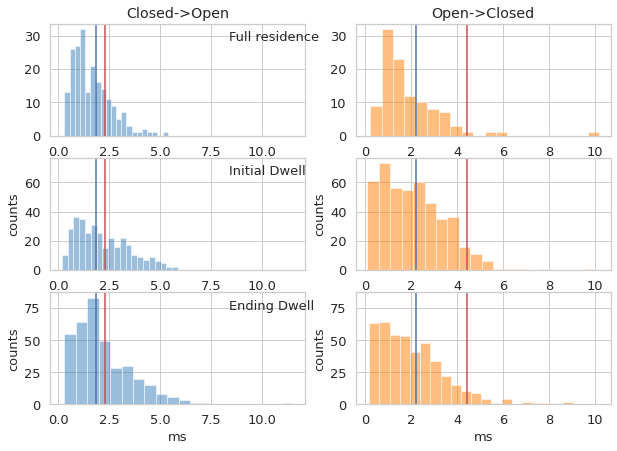

In [67]:
#########################################################################
# Function like inputs, so cell can be coppied and only lines at the top
# need to be changed
mpdata = mpdata_fret
state_str = state_names_fret
fname = filename.split('.hdf5')[0]
fplot_name = 'DCBS'
# End of function-like inputs
#########################################################################

# build figure axes
nstate = mpdata.models.ideal + 1
ngraphs = (nstate)*(nstate - 1) // 2
nrows = ngraphs // 2 + (ngraphs % 2)
fig3 = plt.figure(figsize=(21,nrows*7))
gs3 = gridspec.GridSpec(nrows=3*nrows,ncols=4,figure=fig3)
ax3 = [[] for i in range(ngraphs)]
k = 0
stats_frame = mpdata.models[mpdata.models.ideal].stats_frame()
for i in range(nstate):
    for j in range(i+1,nstate):
        macro_row, macro_col = 3*(k//2), 2*(k%2)
        ax3[k].append(fig3.add_subplot(gs3[macro_row,macro_col]))
        bhm.dwell_trans_dur_hist(mpdata.models, from_state=i, to_state=j, ax=ax3[k][0], color=clr[i], 
                                 include_beg=False)
        ax3[k][0].axvline(1000/mpdata.models.trans[i,j],color='r')
        ax3[k][0].axvline(stats_frame[f'to_state_{j}_dwell_dur'][i], color='b')
        ax3[k][0].annotate('Full residence',(0.7,0.85),xycoords='axes fraction')
        ax3[k].append(fig3.add_subplot(gs3[macro_row+1,macro_col],sharex=ax3[k][0]))
        bhm.dwell_dur_hist(mpdata.models, ax=ax3[k][1], states=i, 
                           dwell_pos=lambda model: bhm.begin_dwell(model)*bhm.dwell_trans(model, j),
                           color=clr[i])
        ax3[k][1].axvline(1000/mpdata.models.trans[i,j],color='r')
        ax3[k][1].axvline(stats_frame[f'to_state_{j}_dwell_dur'][i], color='b')
        ax3[k][1].annotate('Initial Dwell',(0.7,0.85),xycoords='axes fraction')
        ax3[k].append(fig3.add_subplot(gs3[macro_row+2,macro_col],sharex=ax3[k][1]))
        bhm.dwell_dur_hist(mpdata.models, ax=ax3[k][2], states=i, 
                           dwell_pos=lambda model: bhm.end_dwell(model)*bhm.dwell_trans_from(model, j),
                           color=clr[i])
        ax3[k][2].annotate('Ending Dwell',(0.7,0.85),xycoords='axes fraction')
        ax3[k][2].axvline(1000/mpdata.models.trans[i,j],color='r')
        ax3[k][2].axvline(stats_frame[f'to_state_{j}_dwell_dur'][i], color='b')
        ax3[k].append(fig3.add_subplot(gs3[macro_row,macro_col+1],sharey=ax3[k][0]))
        bhm.dwell_trans_dur_hist(mpdata.models, from_state=j, to_state=i, ax=ax3[k][3], color=clr[j], 
                                 include_beg=False)
        ax3[k][3].axvline(1000/mpdata.models.trans[j,i],color='r')
        ax3[k][3].axvline(stats_frame[f'to_state_{i}_dwell_dur'][j], color='b')
        ax3[k].append(fig3.add_subplot(gs3[macro_row+1,macro_col+1],sharey=ax3[k][1],sharex=ax3[k][3]))
        bhm.dwell_dur_hist(mpdata.models, ax=ax3[k][4], states=j, 
                           dwell_pos=lambda model: bhm.begin_dwell(model)*bhm.dwell_trans(model, i),
                           color=clr[j])
        ax3[k][4].axvline(1000/mpdata.models.trans[j,i],color='r')
        ax3[k][4].axvline(stats_frame[f'to_state_{i}_dwell_dur'][j], color='b')
        ax3[k].append(fig3.add_subplot(gs3[macro_row+2,macro_col+1],sharey=ax3[k][2],sharex=ax3[k][4]))
        bhm.dwell_dur_hist(mpdata.models, ax=ax3[k][5], states=j, 
                           dwell_pos=lambda model: bhm.end_dwell(model)*bhm.dwell_trans_from(model, i),
                           color=clr[j])
        ax3[k][5].axvline(1000/mpdata.models.trans[j,i],color='r')
        ax3[k][5].axvline(stats_frame[f'to_state_{i}_dwell_dur'][j], color='b')
        ax3[k].append(fig3.add_subplot(gs3[macro_row:macro_row+3,macro_col]))
        ax3[k][6].axis('off')
        ax3[k][6].set_title(state_str[i] + '->' + state_str[j])
        ax3[k].append(fig3.add_subplot(gs3[macro_row:macro_row+3,macro_col+1]))
        ax3[k][7].axis('off')
        ax3[k][7].set_title(state_str[j] + '->' + state_str[i])
        k += 1
# fig3.savefig('figures/'+fname + fplot_name + '_dwellhist.pdf',format='pdf',bbox_inches='tight')

*Write your caption in this cell, below is sample caption.*
*Frames should stay the same, so you can use it as a template*

**Analysis of the $t_{dwell}$ distributions of *Viterbi* based on each state, for the DCBS selection of the DNA hairpin at 300 mM NaCl.** 
*Top row:* dwells which begin and end within a burst. 
*Middle row:* dwells which begin at the beginning of a burst. 
*Bottom row:* dwells which end at the end of a burst. 
*Right column:* dwells in the closed state, transitioning to the open state. 
*Left column:* dwells in the open state, transitioning to the closed state.

<a id='fret_lifetime'></a>
## Assement of Quantum Yield through the Lifetime data

Since we alread set the decays, we can proceed direclty to plotting:

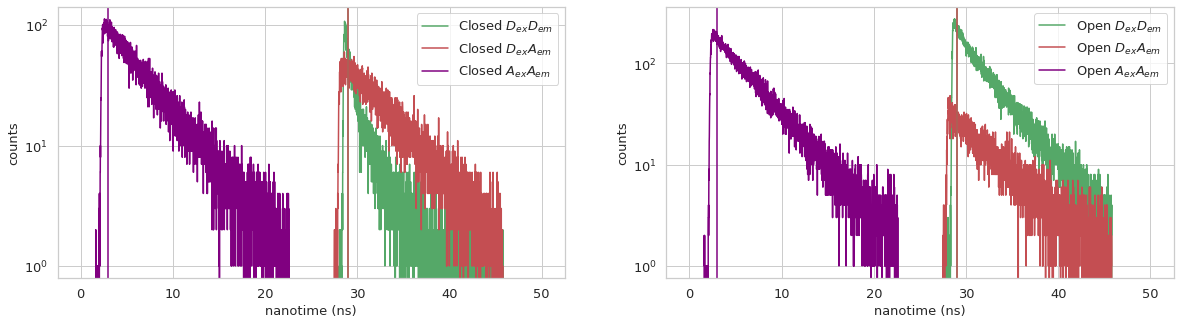

In [68]:
mpdata = mpdata_fret
state_names = state_names_fret

# build figure axes
fig_nt = plt.figure(figsize=(20,5*((mpdata.models.ideal + 1) // 2) ))
gs_nt = gridspec.GridSpec(ncols=2,nrows=((mpdata.models.ideal + 1) // 2))
ax_nt = [fig_nt.add_subplot(gs_nt[i//2, i%2]) for i in range(mpdata.models.ideal+1)]

mpdata.irf_thresh = raw_thresholds

for i, state in enumerate(state_names):
    bhm.state_nanotime_hist(mpdata.models, ax=ax_nt[i], states=i, 
                            streams=mpdata.ph_streams, stream_kwargs=st_kw(state, mpdata), 
                            raw_bin=False)
    ax_nt[i].legend()
    bhm.axline_irf_thresh(mpdata, ax=ax_nt[i], 
                          stream_kwargs=[{'color':stream_color[sel]} for sel in mpdata.ph_streams], 
                          raw_bin=False)
    

Since the IRF is excluded, the mean arrival time can be calculated, which allows us to calculate the lifetime

array([[2.60058641, 4.42708834, 4.33583371],
       [3.58457644, 4.58374682, 4.08592156]])

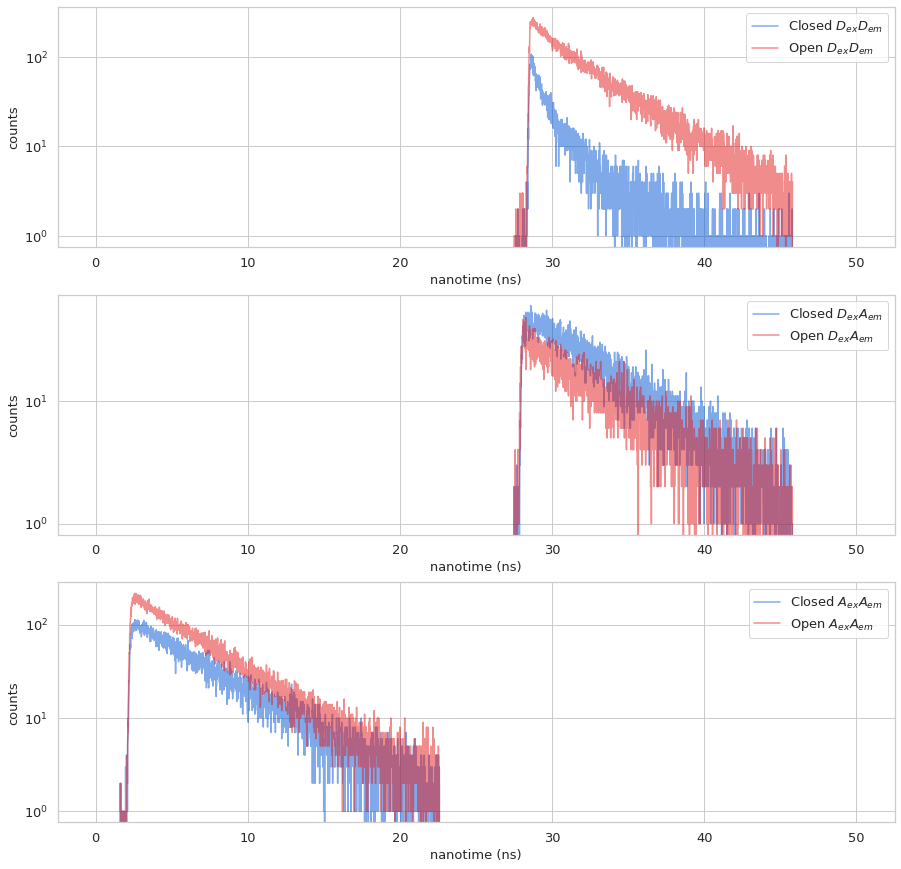

In [69]:
#########################################################################
# Function like inputs, so cell can be coppied and only lines at the top
# need to be changed
mpdata = mpdata_fret
state_names = state_names_fret
state_names = state_names_fret
# End of function-like inputs
#########################################################################

# build figure axes
fig_nt = plt.figure(figsize=(15,5*len(mpdata.ph_streams)))
gs_nt = gridspec.GridSpec(ncols=1,nrows=len(mpdata.ph_streams))
ax_nt = [fig_nt.add_subplot(gs_nt[j,0]) for j in range(len(mpdata.ph_streams))]

for i, stream in enumerate(mpdata.ph_streams):
    bhm.state_nanotime_hist(mpdata.models, streams=stream, ax=ax_nt[i], 
                            state_kwargs=[{'label':f'{state} {stream_label[stream]}'} for state in state_names],
                           alpha=0.5)
    ax_nt[i].legend()

# fig_nt.savefig('figures/'+fname+'DA_decays.pdf',format='pdf',bbox_inches='tight')
mpdata.models.state_nano_mean

*Write your caption in this cell, below is sample caption.*
*Frames should stay the same, so you can use it as a template*

**Comparison of fluorescent lifetime decays of states derived from *Viterbi* analysis, based on FRET burst selection.** 
*Top panel:* Donor decays, ($D_{ex}D_{em}$). 
*Middle panel:* Acceptor FRET decays ($D_{ex}A_{em}$), 
*Bottom panel:* ($A_{ex}A_{em}$).

## Saving Results

While before we had to manually write a function to save to csv, [H2MM_result](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result) objects have the [H2MM_result.stats_frame()](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#burstH2MM.BurstSort.H2MM_result.stats_frame) method, which generates a pandas dataframe, which can be saved as a with built in methods.

In [70]:
for state, result in enumerate(mpdata_da.models):
    result.stats_frame().to_csv(f'{filename.split(".hdf5")[0]}_da_state{state}.csv')
for state, result in enumerate(mpdata_fret.models):
    result.stats_frame().to_csv(f'{filename.split(".hdf5")[0]}_fret_state{state}.csv')

Let's see how long this notebook has been running:

In [71]:
plot_time = time.perf_counter()
printtime(h2mm_time,plot_time,'Plotting took: ')
printtime(begin,plot_time,'The whole analysis up to this point has taken: ')

Plotting took:  0h 0m 39.1891s to run
The whole analysis up to this point has taken:  0h 24m 5.2737s to run


All done!